In [1]:
import os
import h5py
import numpy
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import time
from scipy.signal import savgol_filter
from scipy.io import loadmat
import re
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
import open3d as o3
%matplotlib qt5

In [2]:
def matlab_timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromordinal(int(i) - 366) + timedelta(days=i%1) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromtimestamp(i) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def zscore(array):
    mean = array.mean()
    std = np.std(array)
    return((array-mean)/std)

def ms_from_start(datetimes):
    return(((datetimes-datetimes[0])/1000).astype(np.float64))

def get_mean_brightness(h5file, inds):
    lefts, rights = [], []
    for ind in inds:
        left = cv2.imdecode(h5file['left'][ind],0)
        right =  cv2.imdecode(h5file['right'][ind],0)
        lefts.append(left.mean())
        rights.append(right.mean())
    return(np.vstack((lefts, rights)).mean(axis=0))

def calculate_hist(array,binedges):
    binedges[0] = -np.inf
    binedges[-1] = np.inf
    histogram, bin_edges = np.histogram(array,binedges)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    return(histogram,bincenters)

def smooth(array, window_size=5):
    assert(window_size%2==1)
    filt = np.ones(window_size)/window_size
    # print(filt.sum())
    assert(abs(filt.sum()-1)<1e-6)
    
    return(np.convolve(array,filt, mode='same'))

def align_cameras_on_timestamps(filelist,master='right_post', WINDOW_SIZE=500,
                               use_window=True,max_distance=8):
    # WINDOW_SIZE=500
    # max_distance = 6 # ms
    
    frames = {}
    timestamps = {}
    sestimes = {}
    # filelist.sort()
    for key, file in filelist.items():
        if not file.endswith('_metadata.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
            sestime = f['sestime'][:]
        # key = os.path.basename(file)[:-3]
        frames[key] = framecounts
        timestamps[key] = timestamp
        sestimes[key]  = sestime
    N = len(frames[master])
    camera_LUT = np.array((N,len(frames)), dtype=np.uint64)
    slaves = [i for i in list(frames.keys()) if i!=master]
    N = len(frames[master])
    camera_LUT = np.zeros((N,len(frames)), dtype=np.float64)
    
    for i in range(0,N):
        camera_LUT[i,0] = i
        t = timestamps[master][i]
        min_search = max(0,i-WINDOW_SIZE)
        
        for j, slave in enumerate(slaves):
            max_search = min(len(frames[slave]),i+WINDOW_SIZE)
            # happens when there are large differences in numbers of images between two files
            # this likely means the master has way more images than the slave
            if max_search<=min_search:
                camera_LUT[i,j+1]=np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[slave][min_search:max_search]-t).astype(np.float32)/1000)
            else:
                snippet = np.abs((timestamps[slave]-t).astype(np.float32)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            
            if mint < max_distance:
                val = argmin + min_search
            else:
                val = np.nan
            
            camera_LUT[i,j+1] = val
    
    # data = np.hstack((camera_LUT, timestamps[master]))
    df = pd.DataFrame(camera_LUT, columns=[master]+slaves)
    df['timestamps'] = timestamps[master]
    
    return(df)


def get_timestamps(virmendir, realsensedir):
    timestamps = {}
    
    # get virmen data as a dictionary
    virfiles = os.listdir(virmendir)
    virfiles.sort()
    varnames_file = [os.path.join(virmendir, i) for i in virfiles if 
                    'BinaryVariableNames' in i][0]
    
    mat = loadmat(varnames_file,squeeze_me=True)
    varnames = mat['saveOnIter']
    variables = []
    cnt=0
    for entry in varnames:
        name, n = entry
        if n > 1:
            for i in range(n):
                variables.append('%s%d' %(name,i))
        else:
            variables.append(name)
    binary_file = [os.path.join(virmendir, i) for i in virfiles if 
                  'iterBinary.bin' in i][0]
    rawdata = np.fromfile(binary_file, dtype=np.float64).reshape(-1,len(variables))
    data = {key:rawdata[:,i] for i,key in enumerate(variables)}
    timestamps['virmen'] = matlab_timestamp_to_numpy(data['timeStamp'])
    
    files = os.listdir(realsensedir)
    files.sort()
    
    eye_datafile = [os.path.join(realsensedir, i) for i in files if 'eyeData.mat' in i][0]
    eyedata = loadmat(eye_datafile, squeeze_me=True)
    timestamps['eye'] = matlab_timestamp_to_numpy(np.array([i[0] for i in eyedata['data']]))
    
    filelist = {os.path.basename(i)[:-3]:os.path.join(datadir, i) for i in files if i.endswith('t.h5')}
    for cam, file in filelist.items():
        if not file.endswith('_metadata.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
        timestamps[cam] = timestamp
    return(timestamps)

def align_signals_by_timestamps(timestamps, master='virmen',use_window=True,WINDOW_SIZE=1000,max_distance=7):
    assert(type(timestamps)==dict)
    assert(master in timestamps.keys())
    
    N = len(timestamps[master])
    keys = timestamps.keys()
    
    offsets = {}
    t0 = timestamps[master][0]
    for key in keys:
        if key != master:
            offsets[key] = np.abs(timestamps[key] - t0).argmin()
    # LUT = np.zeros()
    LUT = np.zeros((N,len(timestamps)-1), dtype=np.float64)
    timestamp_matrix = np.zeros((N,len(timestamps)-1), dtype='datetime64[us]')
    j=-1
    original_window = WINDOW_SIZE
    for key,offset in offsets.items():
        j+=1
        WINDOW_SIZE = original_window
        for i in range(0,N):
            t = timestamps[master][i]
            
            min_search = max(0, i+offset-WINDOW_SIZE)
            max_search = min(len(timestamps[key]), i+offset+WINDOW_SIZE)
            
            if max_search <=min_search:
                LUT[i,j] = np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[key][min_search:max_search]-t).astype(np.float64)/1000)
            else:
                snippet = np.abs((timestamps[key]-t).astype(np.float64)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            if mint < max_distance:
                LUT_val = argmin + min_search
                nearest_timestamp = timestamps[key][argmin+min_search]
            else:
                LUT_val = np.nan
                nearest_timestamp = np.datetime64('NaT')
                WINDOW_SIZE+=1
            LUT[i,j] = LUT_val
            timestamp_matrix[i,j] = nearest_timestamp
    LUT = np.hstack((np.arange(0,N)[...,np.newaxis], LUT))
    # data = np.hstack((camera_LUT, timestamps[master]))
    LUT = pd.DataFrame(LUT, columns=[master]+list(offsets.keys()))
    
    timestamp_matrix = np.hstack((timestamps[master][...,np.newaxis], timestamp_matrix))
    timestamp_matrix = pd.DataFrame(timestamp_matrix, columns=[master]+list(offsets.keys()))
    #     df[master] = timestamps[master]
    # df['timestamps'] = timestamps[master]
    
    return(LUT, timestamp_matrix)

def get_virmen_iterdata(virmendir):
    timestamps = {}
    
    # get virmen data as a dictionary
    virfiles = os.listdir(virmendir)
    virfiles.sort()
    varnames_file = [os.path.join(virmendir, i) for i in virfiles if 
                    'BinaryVariableNames' in i][0]
    
    mat = loadmat(varnames_file,squeeze_me=True)
    varnames = mat['saveOnIter']
    variables = []
    cnt=0
    for entry in varnames:
        name, n = entry
        if n > 1:
            for i in range(n):
                variables.append('%s%d' %(name,i))
        else:
            variables.append(name)
    binary_file = [os.path.join(virmendir, i) for i in virfiles if 
                  'iterBinary.bin' in i][0]
    rawdata = np.fromfile(binary_file, dtype=np.float64).reshape(-1,len(variables))
    data = {key:rawdata[:,i] for i,key in enumerate(variables)}
    return(data)

def get_frames_by_index(camfiles, LUT, index, blank_frame=False, shape=(480,640)):
    lefts = {}
    rights = {}
    row = LUT.iloc[index,:]
    # t = np.datetime64(row['timestamps'])
    for camname, file in camfiles.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            with h5py.File(file, 'r') as f:
                left = cv2.imdecode(f['left'][camind],0)
                right = cv2.imdecode(f['right'][camind],0)
        else:
            if blank_frame:
                if len(lefts)> 0:
                    left = np.zeros_like(lefts[0])
                    right = np.zeros_like(rights[0])
                else:
                    left = np.zeros(shape, dtype=np.uint8)
                    right = np.zeros(shape, dtype=np.uint8)
            else:
                left, right = None, None
        lefts[camname] = left
        # lefts.append(left)
        rights[camname] = right
        # rights.append(right)
    return(lefts, rights)

# Calibrate!!!

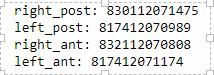

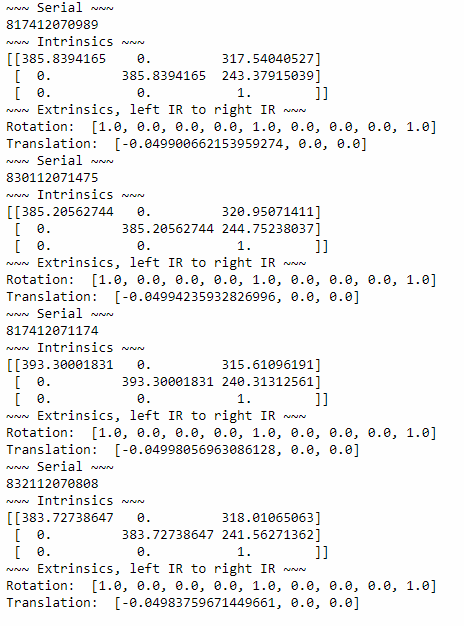

In [5]:
datadir = r'/media/jim/FASTER/realsense/sofia/Calibration190516_190516_141616/'
calibdir = datadir

In [6]:
# OPTIONAL: move files over!!
# import shutil
# contents = os.listdir(datadir)
# contents.sort()
# imdir = os.path.join(datadir, 'images')
# if not os.path.isdir(imdir):
#     os.makedirs(imdir)
# images = [os.path.join(datadir, i) for i in contents if i.endswith('.bmp')]
# for i in tqdm(range(len(images))):
#     src = images[i]
#     dst = os.path.join(imdir, os.path.basename(src))
#     shutil.move(src,dst)

In [7]:
# calibdir = r'/media/jim/FASTER/realsense/calibration_60hz_190507_115348/'
files = os.listdir(calibdir)
files.sort()

camnames = ['left_ant', 'left_post', 'right_ant', 'right_post']
calibfiles = {}
for camname in camnames:
    for file in files:
        if '.h5' in file and camname in file:
            calibfiles[camname] = os.path.join(calibdir,file)
            
if 'images' in files:
    imdir = os.path.join(calibdir, 'images')
else:
    imdir = calibdir
    
files = os.listdir(imdir)
files.sort()
calibims = {camname:[] for camname in camnames}
pattern = re.compile('\d{4}.bmp$')
for camname in camnames:
    for file in files:
        match = pattern.search(file)
        if match and camname in file:
            fullfile = os.path.join(imdir, file)
            calibims[camname].append(fullfile)
            assert(os.path.isfile(fullfile))
# calibfiles = {camname:os.path.join(calibdir, i) for camname, i in zip(camnames,calibfiles) 
#               if i==camname +'_metadata.h5'}
print(calibfiles)

{'left_ant': '/media/jim/FASTER/realsense/sofia/Calibration190516_190516_141616/left_ant_metadata.h5', 'left_post': '/media/jim/FASTER/realsense/sofia/Calibration190516_190516_141616/left_post_metadata.h5', 'right_ant': '/media/jim/FASTER/realsense/sofia/Calibration190516_190516_141616/right_ant_metadata.h5', 'right_post': '/media/jim/FASTER/realsense/sofia/Calibration190516_190516_141616/right_post_metadata.h5'}


In [11]:
with h5py.File(calibfiles['left_ant'], 'r') as f:
    print(f['extrinsics'][:])

[[ 1.          0.          0.         -0.04985865]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]]


In [3]:
# intrinsics = {}
# intrinsics['left_post'] = np.array([[385.8394165, 0, 317.54],[0,385.839,243.379],[0,0,1]])
# intrinsics['right_post'] = np.array([[385.2056, 0, 320.9507],[0,385.2056,244.7523],[0,0,1]])
# intrinsics['left_ant']  = np.array([[393.30001, 0, 315.6109],[0,393.30001,240.3131],[0,0,1]])
# intrinsics['right_ant'] = np.array([[383.727, 0, 318.0106],[0,383.727,241.5627],[0,0,1]])

# extrinsics = {}
# extrinsics['left_post'] = np.hstack((np.eye(3,3), np.array([-0.04990066,0,0])[...,np.newaxis]))
# extrinsics['right_post'] = np.hstack((np.eye(3,3), np.array([-0.04994235,0,0])[...,np.newaxis]))
# extrinsics['left_ant'] = np.hstack((np.eye(3,3), np.array([-0.04998056,0,0])[...,np.newaxis]))
# extrinsics['right_ant'] = np.hstack((np.eye(3,3), np.array([-0.04983759,0,0])[...,np.newaxis]))

# P_l = {}
# P_r = {}
# for camname in list(extrinsics.keys()):
#     this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
#     P_l[camname] = np.dot(intrinsics[camname], this_P_l)
#     P_r[camname] = np.dot(intrinsics[camname], extrinsics[camname])
# print(extrinsics)

{'left_post': array([[ 1.        ,  0.        ,  0.        , -0.04990066],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]]), 'right_post': array([[ 1.        ,  0.        ,  0.        , -0.04994235],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]]), 'left_ant': array([[ 1.        ,  0.        ,  0.        , -0.04998056],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]]), 'right_ant': array([[ 1.        ,  0.        ,  0.        , -0.04983759],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])}


In [12]:
intrinsics = {}
extrinsics = {}
P_l = {}
P_r = {}
for cam in camnames:
    with h5py.File(calibfiles[cam], 'r') as f:
        intrinsics[cam] = f['intrinsics'][:]
        extrinsics[cam] = f['extrinsics'][:]
        this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
        P_l[cam] = intrinsics[cam] @ this_P_l
        P_r[cam] = intrinsics[cam] @ extrinsics[cam]

In [13]:
np.set_printoptions(suppress=True)

In [14]:
LUT = align_cameras_on_timestamps(calibfiles, max_distance=20,WINDOW_SIZE=10000, use_window=False)

## Verify image and corner quality

In [16]:
def get_frames_by_index_uncompressed(calibims, LUT, index):
    camnames = list(calibims.keys())
    lefts = {}
    rights = {}
    row = LUT.iloc[index,:]
    # t = np.datetime64(row['timestamps'])
    for camname, filelist in calibims.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            im = cv2.imread(filelist[camind],0)
            H,W = im.shape
            left = im[:,:W//2]
            right = im[:, W//2:]
        else:
            left, right = None,None
        lefts[camname] = left
        rights[camname] = right
        # lefts.append(left)
        # rights.append(right)
    return(lefts,rights)

In [17]:
def find_corners_in_image(img):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 0, 0.00001)
    chessboard_columns=9
    chessboard_rows=6
    square_size_mm=6

    ret, corners = cv2.findChessboardCorners(img, (chessboard_rows, chessboard_columns))
    if ret:
        # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 0,.00001)
        corners = cv2.cornerSubPix(img,corners,(5,5),(-1,-1),criteria)
        return(corners)
    else:
        return(None)

In [24]:
def plot_corners(corners, ax=None, text=True,cmap='viridis', **kwargs):
    if corners is None:
        return
    if ax is None:
        ax = plt.gca()
    if type(corners) != np.ndarray:
        raise ValueError('invalid inputs!')
    if corners.shape[0] == 2:
        corners = corners.T
    # print(corners.shape)
    
    x = corners.squeeze()[:,0]
    y = corners.squeeze()[:,1]
    inds = np.arange(len(x))
    cmap = plt.get_cmap('viridis')
    
    if text:
        for i in inds:
            ax.text(x[i],y[i],s=str(i), 
                   color=cmap(i/len(inds)))
    else:
        ax.plot(x,y,'rx', **kwargs)
    

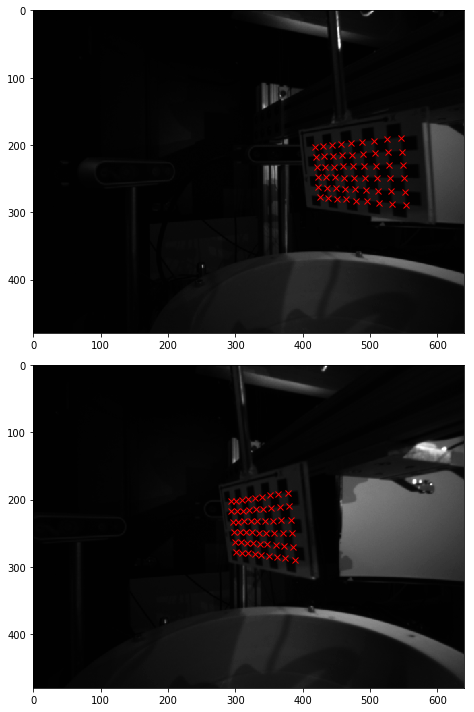

In [36]:
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, np.random.randint(low=0,high=len(LUT)))

fig, ax = plt.subplots(2,1,figsize=(12,10))
# fig.clear()
# camind = np.random.randint(low=0,high=len(rights))
cams = list(lefts.keys())
cam = cams[np.random.randint(low=0,high=len(lefts))]
im = lefts[cam]
rim = rights[cam]

ax[0].imshow(im, 'gray')
corners = find_corners_in_image(im)
if corners is not None:
    x = corners[:,:,0]
    y = corners[:,:,1]
    plot_corners(corners, ax[0], text=False)
    
ax[1].imshow(rim, 'gray')
corners = find_corners_in_image(rim)
if corners is not None:
    x = corners[:,:,0]
    y = corners[:,:,1]
    plot_corners(corners, ax[1], text=False)
# ax.plot(x, y, 'ro',markersize=2.5, alpha=0.5)


plt.tight_layout()
plt.show()

## Get corners from every image in the directory

In [37]:
def get_corners_and_names(calibims, LUT, index):
    filenames = get_filenames_by_index(calibims, LUT, index)
    corners = get_corners_by_row(calibims, LUT, index)
    return(filenames, corners)

def append_corners_to_file(calibims, LUT, index, h5file):
    filenames = get_filenames_by_index(calibims, LUT, index)
    corners = get_corners_by_row(calibims, LUT, index)
    
    camnames = list(calibims.keys())
    
    # print(list(h5file.keys()))
    for cam in camnames:
        h5file[cam + '/imfiles'][index] = filenames[cam]
        # print(corners[cam + '_l'].shape)
        h5file[cam + '/corners/l'][index] = corners[cam + '_l'].flatten()
        h5file[cam + '/corners/r'][index] = corners[cam + '_r'].flatten()
        
def get_filenames_by_index(calibims, LUT, index):
    camnames = list(calibims.keys())
    names = {}
    # rights = []
    row = LUT.iloc[index,:]
    # t = np.datetime64(row['timestamps'])
    for camname, filelist in calibims.items():
        camind = row[camname]
        if not np.isnan(camind):
            name = filelist[int(camind)]
        else:
            name = None
        names[camname] = name
    return(names)

def get_corners_by_row(calibims, LUT, i):
    lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, i)
    this_dict = {}
    # print(len(camnames))
    # print(len(lefts))
    nan = np.array((np.nan,)).astype(np.float32)
    for camname in camnames:
        left = lefts[camname]
        right = rights[camname]
        if left is not None:
            corners_l = find_corners_in_image(left)
            this_dict[camname+'_l'] = corners_l if corners_l is not None else nan
        else:
            this_dict[camname+'_l'] = nan
            
        if right is not None:
            corners_r = find_corners_in_image(right)
            this_dict[camname+'_r'] = corners_r if corners_r is not None else nan
        else:
            this_dict[camname+'_r'] = nan
        
    return(this_dict)

In [38]:
def write_corners_to_file(camnames, calibdir, LUT, num_workers=16, shape=[54,1,2]):
    
    files = os.listdir(calibdir)
    files.sort()
    if 'images' in files:
        imdir = os.path.join(calibdir, 'images')
        imfiles = os.listdir(imdir)
        imfiles.sort()
    else:
        imdir = calibdir
        imfiles = files
        
    calibfiles = {}
    calibims = {camname:[] for camname in camnames}
    pattern = re.compile('\d{4}.bmp$')
    for camname in camnames:
        for file in imfiles:
            match = pattern.search(file)
            if match and camname in file:
                fullfile = os.path.join(imdir, file)
                calibims[camname].append(fullfile)
                assert(os.path.isfile(fullfile))
    
    cornerfile = os.path.join(calibdir, 'corners.h5')
    N = len(LUT)
    # camnames = list(calibims.keys())
    
    with h5py.File(cornerfile, 'w') as f:
        floattype = h5py.special_dtype(vlen=np.dtype('float32'))
        strtype = h5py.special_dtype(vlen=str)

        for cam in camnames:
            group = f.create_group(cam)

            ds = group.create_dataset('imfiles', (N,), dtype=strtype)
            # ds = subgrp.create_dataset('l',
            # ds = subgrp.create_dataset('r', (N,), dtype=strtype)

            subgrp = group.create_group('corners')
            ds = subgrp.create_dataset('l', (N,), dtype=floattype)
            ds = subgrp.create_dataset('r', (N,), dtype=floattype)
        f['shape'] = shape
        # f[cam + '/corners/l'][0] = np.array((np.nan,)).astype(np.float32)
        # append_corners_to_file(calibims, LUT, 100, f)
        tuples = [(calibims, LUT, i) for i in range(N)]
        with mp.Pool(num_workers) as pool:
            res = pool.starmap(get_corners_and_names, tuples)
            
        for cam in camnames:
            for index in range(N):
                filenames, corners = res[index]

                f[cam + '/imfiles'][index] = filenames[cam]
                # print(corners[cam + '_l'].shape)
                f[cam + '/corners/l'][index] = corners[cam + '_l'].flatten()
                f[cam + '/corners/r'][index] = corners[cam + '_r'].flatten()

In [39]:
camnames = ['left_ant', 'left_post', 'right_ant', 'right_post']

cornerfile = os.path.join(calibdir, 'corners.h5')
if os.path.isfile(cornerfile):
    print('Corners already computed!')
else:
    write_corners_to_file(camnames,calibdir, LUT)

In [40]:
def get_corners_from_file(calibdir, index):
    h5file = os.path.join(calibdir, 'corners.h5')
    corners = {}
    with h5py.File(h5file, 'r') as f:
        shape = f['shape'][:]
        camnames = [i for i in list(f.keys()) if 'left' in i or 'right' in i]
        # print(camnames)
        for cam in camnames:
            # import pdb
            # pdb.set_trace()
            corner = f[cam + '/corners/l'][index]
            if len(corner) > 1:
                corner = corner.reshape(shape)
            else:
                corner = None
            corners[cam + '_l'] = corner
            
            corner =  f[cam + '/corners/r'][index]
            if len(corner) > 1:
                corner = corner.reshape(shape)
            else:
                corner = None
            corners[cam + '_r'] = corner
            # corners[cam + '_r'] = f[cam + '/corners/r'][index].reshape(shape)
    return(corners)

def get_images_and_corners(calibdir, calibims, LUT, index):
    lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, index)
    corners = get_corners_from_file(calibdir, index)
    return(lefts, rights, corners)

def get_valid_camera_pairs(calibdir, cams):
    h5file = os.path.join(calibdir, 'corners.h5')
    with h5py.File(h5file, 'r') as f:
        N = f[cams[0] + '/corners/l'].shape[0]

        all_valid = np.zeros((N,len(cams)), dtype=np.uint8)
        for i in range(len(cams)):
            l = f[cams[i] + '/corners/l'][:]
            r = f[cams[i] + '/corners/r'][:]
            has_corners =  np.array([0 if np.any(np.isnan(i)) or np.any(np.isnan(j)) else 1 for i,j in zip(l,r)])
            all_valid[:,i] = has_corners
    valid_indices = np.where(all_valid.sum(axis=1)==len(cams))[0]
    return(valid_indices)
        

### for each pair of cameras, find the images that have corners for all 4 images

In [41]:
def triangulate(P_l, P_r, leftpoints, rightpoints):
    points4d = cv2.triangulatePoints(P_l, P_r, leftpoints, rightpoints)
    return(points4d)

In [42]:
def reproject_points(points4d, projection_matrix):
    # points4d = cv2.triangulatePoints(P_l, P_r, leftpoints, rightpoints)
    reprojected = np.dot(projection_matrix, points4d).T
    reprojected= reprojected[:,0:2]/reprojected[:,2:]
    return(reprojected)

In [43]:
import math
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6
 
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    # assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [51]:
cams = ['right_post', 'right_ant']

caminds = []
for i,cam in enumerate(cams):
    caminds.append([i for i in range(len(camnames)) if camnames[i]==cam][0])
    

### Get the indices of images in which the checkerboard can be seen from all 4 cameras of two realsense pairs

In [52]:
valid_indices = get_valid_camera_pairs(calibdir,  cams)

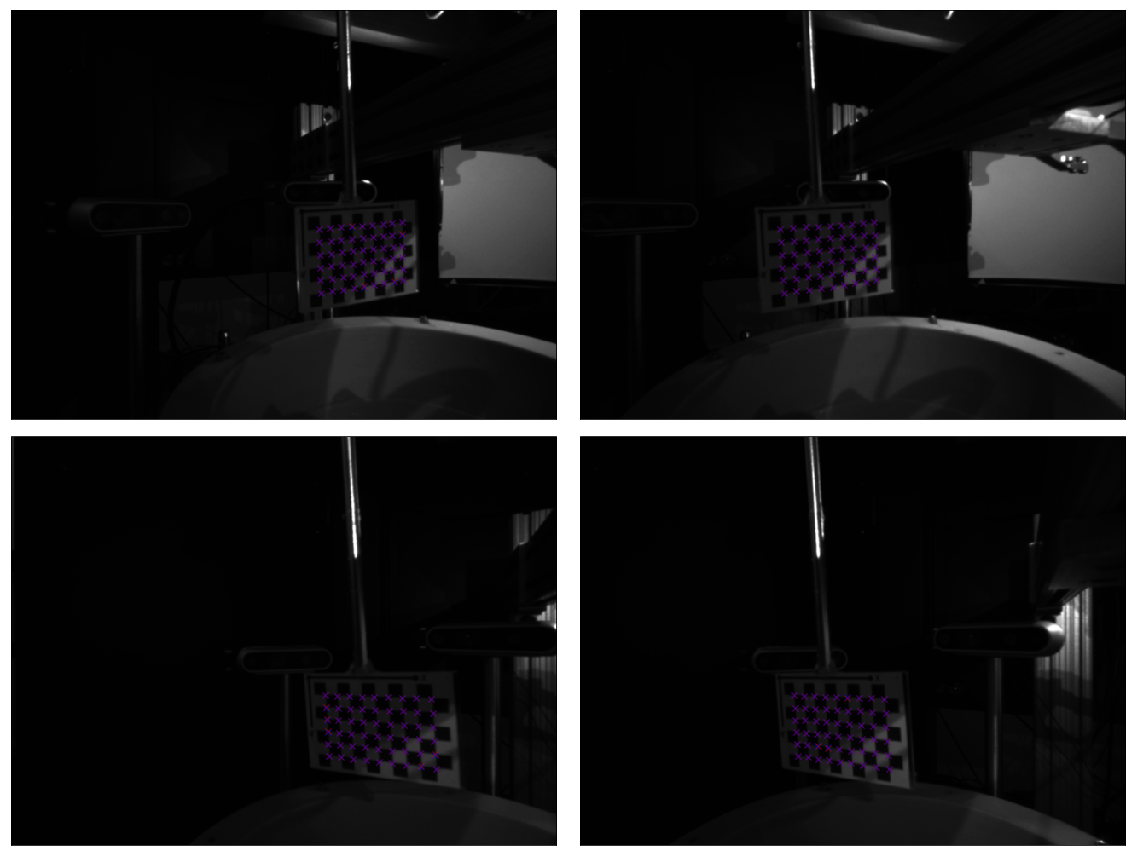

In [57]:
ind = valid_indices[np.random.randint(low=0, high=len(valid_indices))]
corners = get_corners_from_file(calibdir, ind)
# ind = all_there[np.random.randint(low=0,high=len(all_there))]

# corners = all_corners[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)
l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']
left_4d = cv2.triangulatePoints(P_l[cams[0]], P_r[cams[0]], l1, r1)
l1_reprojected = np.dot(P_l[cams[0]], left_4d).T
l1_reprojected= l1_reprojected[:,0:2]/l1_reprojected[:,2:]


fig, ax = plt.subplots(2,2,figsize=(16,12))

points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
l1_reprojected = reproject_points(points4d, P_l[cams[0]])
r1_reprojected = reproject_points(points4d, P_r[cams[0]])
im = lefts[cams[0]]
ax[0,0].imshow(im, 'gray')
plot_corners(l1, ax[0,0],text=False, alpha=0.5, color='r')
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(l1_reprojected, ax[0,0],text=False,alpha=0.5, color='b')
# ax[0,0].plot(l1_reprojected[:,0], l1_reprojected[:,1], color='b',markersize=2.5, alpha=0.5)

im = rights[cams[0]]
ax[0,1].imshow(im, 'gray')
plot_corners(r1, ax[0,1],text=False, alpha=0.5, color='r')
plot_corners(r1_reprojected, ax[0,1],text=False,alpha=0.5, color='b')

points4d = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
l2_reprojected = reproject_points(points4d, P_l[cams[1]])
r2_reprojected = reproject_points(points4d, P_r[cams[1]])
im = lefts[cams[1]]
ax[1,0].imshow(im, 'gray')
plot_corners(l2, ax[1,0], text=False,alpha=0.5, color='r')
plot_corners(l2_reprojected, ax[1,0], text=False,alpha=0.5, color='b')
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# ax[1,0].plot(l2_reprojected[:,0], l2_reprojected[:,1], 'bo',markersize=2.5, alpha=0.5)

im = rights[cams[1]]
ax[1,1].imshow(im, 'gray')
plot_corners(r2, ax[1,1], text=False,alpha=0.5, color='r')
plot_corners(r2_reprojected, ax[1,1], text=False,alpha=0.5, color='b')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# ax[1,1].plot(r2_reprojected[:,0], r2_reprojected[:,1], 'bo',markersize=2.5, alpha=0.5)

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

# View point clouds in 3D

In [58]:
def numpy_to_pcd(array):
    pcd = o3.PointCloud()
    try:
        pcd.points= o3.Vector3dVector(array)
    except RuntimeError:
        print('Error, transposing...')
        pcd.points= o3.Vector3dVector(array.T)
    return(pcd)

In [59]:
points4d_l = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
points4d_r = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

In [75]:
pcd_l = numpy_to_pcd(points4d_l[0:3,:]/points4d_l[3,:])
pcd_r = numpy_to_pcd(points4d_r[0:3,:]/points4d_r[3,:])
o3.draw_geometries([pcd_l, pcd_r])

Error, transposing...
Error, transposing...


In [61]:
leftpoints = []
rightpoints = []

for ind in valid_indices:
    corners = get_corners_from_file(calibdir, ind)
    # corners = all_corners[ind]
    # lefts, rights = get_frames_by_index(calibfiles, LUT, ind)

    l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
    l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']
    
    points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
    leftpoint = points4d[0:3,:]/points4d[3,:]
    points4d =  triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
    rightpoint = points4d[0:3,:]/points4d[3,:]
    leftpoints.append(leftpoint)
    rightpoints.append(rightpoint)
    
leftpoints = np.hstack(leftpoints).T
rightpoints = np.hstack(rightpoints).T

In [76]:
pcd = o3.PointCloud()
pcd.points= o3.Vector3dVector(leftpoints)
pcd.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(rightpoints)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([pcd,pc2])

In [63]:
import numpy as np
import re

def kabsch_rmsd(P, Q):
    """
    Rotate matrix P unto Q using Kabsch algorithm and calculate the RMSD.
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        root-mean squared deviation
    """
    P = kabsch_rotate(P, Q)
    return rmsd(P, Q)


def kabsch_rotate(P, Q):
    """
    Rotate matrix P unto matrix Q using Kabsch algorithm.
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    P : array
        (N,D) matrix, where N is points and D is dimension,
        rotated
    """
    U = kabsch(P, Q)

    # Rotate P
    P = np.dot(P, U)
    return P


def kabsch(P, Q):
    """
    The optimal rotation matrix U is calculated and then used to rotate matrix
    P unto matrix Q so the minimum root-mean-square deviation (RMSD) can be
    calculated.
    Using the Kabsch algorithm with two sets of paired point P and Q, centered
    around the centroid. Each vector set is represented as an NxD
    matrix, where D is the the dimension of the space.
    The algorithm works in three steps:
    - a translation of P and Q
    - the computation of a covariance matrix C
    - computation of the optimal rotation matrix U
    http://en.wikipedia.org/wiki/Kabsch_algorithm
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    U : matrix
        Rotation matrix (D,D)
    Example
    -----
    TODO
    """

    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Computation of the optimal rotation matrix
    # This can be done using singular value decomposition (SVD)
    # Getting the sign of the det(V)*(W) to decide
    # whether we need to correct our rotation matrix to ensure a
    # right-handed coordinate system.
    # And finally calculating the optimal rotation matrix U
    # see http://en.wikipedia.org/wiki/Kabsch_algorithm
    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return U



def centroid(X):
    """
    Calculate the centroid from a vectorset X.
    https://en.wikipedia.org/wiki/Centroid
    Centroid is the mean position of all the points in all of the coordinate
    directions.
    C = sum(X)/len(X)
    Parameters
    ----------
    X : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    C : float
        centeroid
    """
    C = X.mean(axis=0)
    return C


def rmsd(V, W):
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation
    """
    D = len(V[0])
    N = len(V)
    rmsd = 0.0
    for v, w in zip(V, W):
        rmsd += sum([(v[i] - w[i])**2.0 for i in range(D)])
    return np.sqrt(rmsd/N)

In [64]:
def calculate_transformation_kabsch(src_points, dst_points):
    """
    Calculates the optimal rigid transformation from src_points to
    dst_points
    (regarding the least squares error)
    Parameters:
    -----------
    src_points: array
        (3,N) matrix
    dst_points: array
        (3,N) matrix

    Returns:
    -----------
    rotation_matrix: array
        (3,3) matrix

    translation_vector: array
        (3,1) matrix
    rmsd_value: float
    """
    assert src_points.shape == dst_points.shape
    if src_points.shape[0] != 3:
        raise Exception("The input data matrix had to be transposed in order to compute transformation.")

    src_points = src_points.transpose()
    dst_points = dst_points.transpose()

    src_points_centered = src_points - centroid(src_points)
    dst_points_centered = dst_points - centroid(dst_points)

    rotation_matrix = kabsch(src_points_centered, dst_points_centered)
    rmsd_value = kabsch_rmsd(src_points_centered, dst_points_centered)

    translation_vector = centroid(dst_points) - np.matmul(centroid(src_points), rotation_matrix)

    return rotation_matrix.transpose(), translation_vector.transpose(), rmsd_value

# Run kabsch algorithm to rotate points from one camera's coordinate system to the other, then visualize

In [65]:
leftpoints.shape

(21762, 3)

### Actually run!

In [66]:
R, t, quality = calculate_transformation_kabsch(rightpoints.T, leftpoints.T)
print(rotationMatrixToEulerAngles(R)*180/math.pi)
print(t)

[ -0.53077805 -48.11591091  -0.17829128]
[ 0.12569302 -0.0240886   0.0294933 ]


### Transform
Then visualize in 3D. Notice how well they overlap! They should look purple-ish, because the renderer will flip back and forth between blue and red. 

In [67]:
right_in_left = R@rightpoints.T + t[...,np.newaxis]

In [77]:
pcd = o3.PointCloud()
pcd.points= o3.Vector3dVector(leftpoints)
pcd.paint_uniform_color([1,0,0])

pc2 = o3.PointCloud()
pc2.points= o3.Vector3dVector(right_in_left.T)
pc2.paint_uniform_color([0,0,1])

o3.draw_geometries([pcd,pc2])

# Putting it all together

# Iterative calibration: fit, calculate reprojection errors, remove outlier checkerboards

# iterative calibration with kabsch

In [69]:
def corner_list_to_point_clouds(corner_list, cams, P_l, P_r):
    leftpoints = []
    rightpoints = []
    for corners in corner_list:
        # corners = all_corners[ind]
        # lefts, rights = get_frames_by_index(calibfiles, LUT, ind)

        l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
        l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

        points4d = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
        leftpoint = points4d[0:3,:]/points4d[3,:]
        points4d =  triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)
        rightpoint = points4d[0:3,:]/points4d[3,:]

        leftpoint = numpy_to_pcd(leftpoint.T)
        rightpoint = numpy_to_pcd(rightpoint.T)

        o3.estimate_normals(leftpoint, o3.KDTreeSearchParamHybrid(
                radius = 0.1, max_nn = 30))
        o3.estimate_normals(rightpoint, o3.KDTreeSearchParamHybrid(
                radius = 0.1, max_nn = 30))

        leftpoints.append(leftpoint)
        rightpoints.append(rightpoint)
    return(leftpoints, rightpoints)

def combine_point_clouds(source_list, target_list):
    source = o3.PointCloud()
    for i in range(len(source_list)):
        source += source_list[i]
    target = o3.PointCloud()
    for i in range(len(target_list)):
        target += target_list[i]
    return(source,target)

In [70]:
def calculate_reprojection_errors(corners, cams, P_l, P_r, R, t):
    l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
    l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

    points4d_0 = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
    points4d_1 = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

    source_in_target = R@points4d_0[:3,:] + t[...,np.newaxis]
    source_in_target = np.concatenate((source_in_target, np.ones((1,source_in_target.shape[1]))), axis=0)

    pts_l_projected = reproject_points(source_in_target, P_l[cams[1]])
    pts_r_projected = reproject_points(source_in_target, P_r[cams[1]])

    l_dist = np.sqrt(np.sum((pts_l_projected.squeeze()-l2.squeeze())**2, axis=1))
    r_dist = np.sqrt(np.sum((pts_r_projected.squeeze()-r2.squeeze())**2, axis=1))
    
    return(l_dist.mean(), r_dist.mean())

In [71]:
def invert_transform(R,t):
    if type(R) == torch.Tensor or type(R) == torch.nn.parameter.Parameter:
        rot = R.t()
        t = - torch.matmul(rot, t)
    elif type(R) == np.ndarray:
        rot = R.T
        t = - np.matmul(rot, t)
    else:
        raise ValueError('invalid input type: ', type(R))
    return(rot, t)

In [72]:
def generate_projection_matrices(intrinsics, extrinsics):
    # assume the left extrinsic is just the identity
    this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    P_l = np.dot(intrinsics, this_P_l)
    P_r = np.dot(intrinsics, extrinsics)
    return(P_l, P_r)

In [82]:
cams = ['right_post', 'right_ant']
threshold = 5
max_num_iters = 5
num_checkerboards = 10

# cams = ['right_ant', 'right_post']
caminds = []
for i,cam in enumerate(cams):
    caminds.append([i for i in range(len(camnames)) if camnames[i]==cam][0])
valid_indices = get_valid_camera_pairs(calibdir,  cams)
valid_indices = list(valid_indices)
criterion_met = False
iterations = 0
while not criterion_met:

    indices = np.random.choice(valid_indices, size=(num_checkerboards,))

    # for i in iters:
    corner_list = [get_corners_from_file(calibdir, ind) for ind in indices]
    source_list, target_list = corner_list_to_point_clouds(corner_list,
                                                          cams,P_l,P_r)
    # source, target = combine_point_clouds(source_list, target_list)
    #     R,t,transformation, left_combined, right_combined = compute_rigid_transformation(
    #         source_list, target_list,method='icp', distance_threshold=0.005)
    source_points = np.concatenate([np.asarray(i.points) for i in source_list])
    target_points = np.concatenate([np.asarray(i.points) for i in target_list])
    
    R, t, quality = calculate_transformation_kabsch(source_points.T, target_points.T)
    
    l_dists, r_dists = [], []
    for ind in indices:
        corners = get_corners_from_file(calibdir, ind)
        l_dist, r_dist = calculate_reprojection_errors(corners, cams, P_l, P_r, R, t)
        l_dists.append(l_dist)
        r_dists.append(r_dist)
    print('Errors: ', np.mean(l_dists), np.mean(r_dists))
    to_remove = [ind for i,ind in enumerate(indices) if l_dists[i]>threshold or r_dists[i]>threshold]
    for ind in to_remove:
        try:
            valid_indices.remove(ind)
        except ValueError:
            pass
    if len(to_remove)==0 or iterations==max_num_iters:
        criterion_met = True
    iterations+=1

Errors:  4.559564449997864 5.41616256797023
Errors:  3.6449596830029627 4.293370811038504
Errors:  4.01453492315448 4.723739488042186
Errors:  3.930213489014495 4.644699544407503
Errors:  4.174206212644912 4.867720182618781
Errors:  3.88353096905927 4.607022920748458


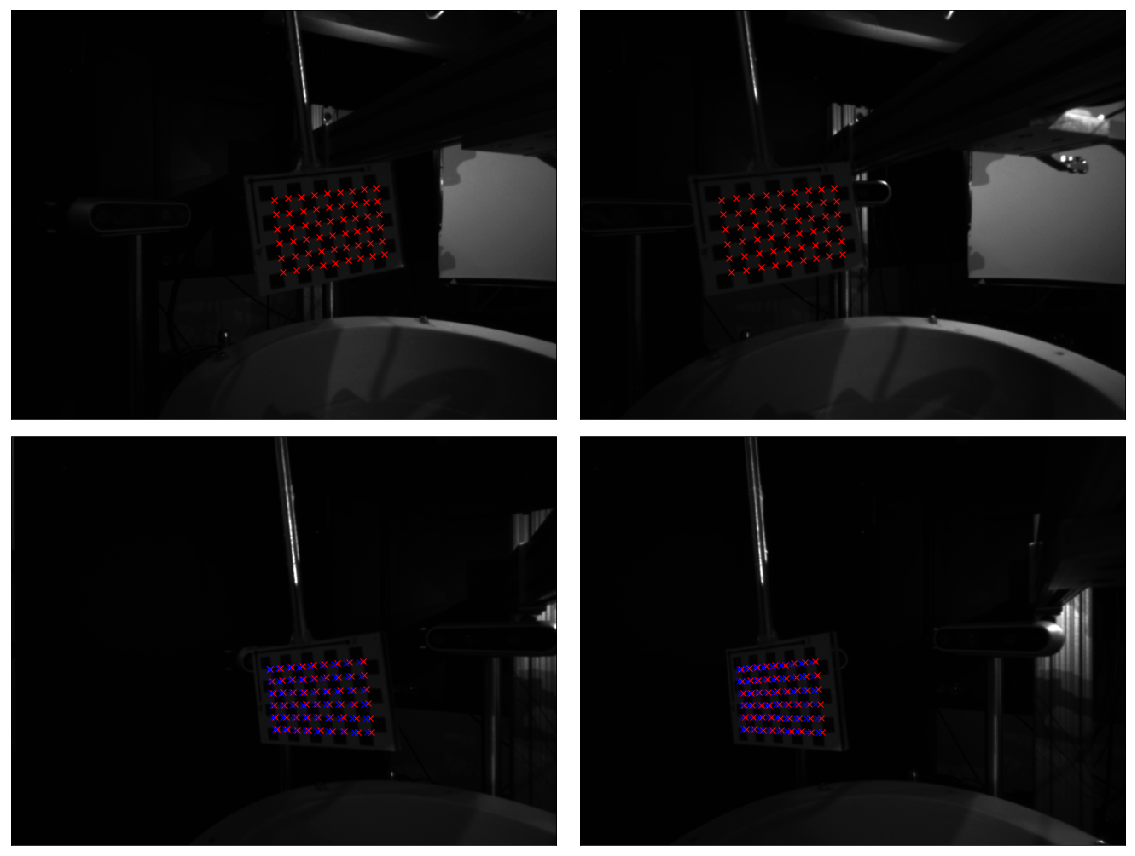

In [83]:
ind = valid_indices[np.random.randint(low=0,high=len(valid_indices))]
# ind = valid_indices[3]

corners = get_corners_from_file(calibdir, ind)
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, ind)

l1, r1 = corners[cams[0]+'_l'], corners[cams[0]+'_r']
l2, r2 = corners[cams[1]+'_l'], corners[cams[1]+'_r']

points4d_0 = triangulate(P_l[cams[0]], P_r[cams[0]], l1, r1)
points4d_1 = triangulate(P_l[cams[1]], P_r[cams[1]], l2, r2)

left_in_right = R@points4d_0[:3,:] + t[...,np.newaxis]
left_in_right = np.concatenate((left_in_right, np.ones((1,left_in_right.shape[1]))), axis=0)
right = points4d_1[:3,:]/points4d_1[3,:]
# left_in_right = transformation@points4d_0

l1_reprojected = reproject_points(left_in_right, P_l[cams[1]])
r1_reprojected = reproject_points(left_in_right, P_r[cams[1]])

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
plot_corners(l1, ax, text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
plot_corners(r1, ax, text=plot_text)
# plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
plot_corners(l2, ax, text=plot_text)
plot_corners(l1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
plot_corners(r2, ax, text=plot_text)
plot_corners(r1_reprojected, ax, color='b',text=plot_text)
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

# Put Kabsch, forwards and backwards rotations, reprojection, and reprojection errors into nice Numpy classes for publishing

# RealsensePair class
* Two cameras: source and target. Each has:
    * Intrinsic
    * Extrinsic
    * 2 projection matrices
* Methods
    * Fit: with two point clouds, use Kabsch to get rotations
    * Calculate reprojection errors: for each simultaneous point cloud, get the mean reprojection error for all 4 images
    * Fit_iterative: just like Calibrator class
    
# Transformer class
* N cameras
* Use Transformer classes to fit pairwise transforms between two adjacent cameras
* Use combinations of pairwise rotations to come up with any arbitrary transform
* Methods
    * transform: (pointcloud, source_cam, dest_cam)
        * Rotate point cloud from source_1 coordinates to dest_cam coordinates

In [230]:
def invert_transform(R,t):
    if type(R) == torch.Tensor or type(R) == torch.nn.parameter.Parameter:
        rot = R.t()
        t = - torch.matmul(rot, t)
    elif type(R) == np.ndarray:
        rot = R.T
        t = - np.matmul(rot, t)
    else:
        raise ValueError('invalid input type: ', type(R))
    return(rot, t)

In [57]:
class PointData():
    """Class for easily generating point clouds from cached checkerboard 'corners.'
    Usage:
        dataset = PointData(...)
        clouds = dataset[0]
        # clouds['left_ant'] = [3,N] array of points
        # clouds['left_post'] = [3,N] array of points
        # ...etc
    """
    def __init__(self, calibdir,cams, intrinsics, extrinsics, valid_indices):
        """Construct PointData object.
        Args:
            Calibdir: directory with cached checkerboard corners
            Cams: list of cameras to return points for, e.g. ['left_ant', 'left_post',...]
            intrinsics: dict of intrinsic matrices. Keys: cams
            extrinsics: dict of extrinsic matrices for converting between realsense 
                L and R sensors. keys: cams
            valid_indices: list of timepoints in calibration session to return points for
        """
        self.valid_indices = valid_indices
        self.calibdir = calibdir
        # self.camnames = camnames
        self.cams = cams
        P_l = {}
        P_r = {}
        # convert intrinsics, extrinsics into projection matrices
        for cam in cams:
            P_l[cam], P_r[cam] = generate_projection_matrices(intrinsics[cam], extrinsics[cam])
        self.P_l = P_l
        self.P_r = P_r
        
    def __len__(self):
        return(len(self.valid_indices))
    def __getitem__(self, index):
        # read corners from disk
        corners = get_corners_from_file(self.calibdir, self.valid_indices[index])
        
        ls,rs,clouds = {},{},{}
        # unpack left and right 'corners' from dictionary
        for cam in self.cams:
            ls[cam],rs[cam] = corners[cam+'_l'], corners[cam+'_r']
        for cam in self.cams:
            l,r = ls[cam],rs[cam]
            # if there's points in both left and right sensors, triangulate
            if l is not None and r is not None:
                # triangulate corners into 4d homogeneous coordinates
                points4d = triangulate(self.P_l[cam], self.P_r[cam], l, r)
                # homogeneous -> euclidean
                clouds[cam] =  points4d[:3,:]/points4d[3,:]
            else:
                clouds[cam] = None
        return(clouds)

In [52]:
class RealsensePair():
    """Class for dealing with pair of neighboring realsenses.
    Handles rigid calibration, projection onto the imaging plane, transforming 
    between their coordinate systems, etc.
    """
    def __init__(self, cams,source_intrinsic, source_extrinsic, target_intrinsic, target_extrinsic):
        """ Constructor for RealsensePair.
        Naming convention: source is one realsense, target is the other.
        
        Args:
            cams: list or tuple of camera names, e.g. ['left', 'right']
            source_intrinsic: 3x3 camera intrinsic matrix for the 'source' camera
            source_extrinsic: 3x4 extrinsic matrix, transforms between the left
                and right SENSORs, assuming the coordinate system is defined relative
                to the left sensor
            target... same as above
            
        """
        this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
        self.P_l_source = np.dot(source_intrinsic, this_P_l)
        self.P_r_source = np.dot(source_intrinsic, source_extrinsic)
        self.P_l_target = np.dot(target_intrinsic, this_P_l)
        self.P_r_target = np.dot(target_intrinsic, target_extrinsic)
        self.cams = cams
        
        self.intrinsics = {}
        self.extrinsics = {}
        self.intrinsics[cams[0]] = source_intrinsic
        self.intrinsics[cams[1]] = target_intrinsic
        self.extrinsics[cams[0]] = source_extrinsic
        self.extrinsics[cams[1]] = target_extrinsic
        
    def append_ones(self, array):
        """Appends a row of ones to a [3,N] array
        Useful for euclidean -> homogeneous coordinate transforms
        """
        return(np.concatenate((array, np.ones((1, array.shape[1]), dtype=array.dtype)), axis=0))
    
    def project(self, x_3d,P):
        """Project point cloud onto imaging plane.
        Args:
            x_3d: [3,N] matrix of points
            P: projection matrix for a given camera sensor
        Outputs:
            [2,N] matrix of points on imaging plane
        """
        assert(x_3d.ndim==2)
        # transform euclidean -> homogeneous coordinates
        homogeneous = self.append_ones(x_3d)
        # project
        homogeneous = P @ homogeneous
        # homogeneous -> euclidean
        return(homogeneous[:2,:]/homogeneous[2,:])
    
    def fit(self, source_cloud, target_cloud):
        """Fits a rigid transform between two point clouds.
        Args:
            source_cloud: 3xN array of points
            target cloud: 3xN array of points
        Outputs:
            R,t: rigid rotation and translation. target_est ~ R @ source + t
            R_inv, t_inv: opposite transformation. source_est ~ R_inv @ target + t_inv
        Method:
            Kabsch algorithm 
            https://en.wikipedia.org/wiki/Kabsch_algorithm
            Implemented by Intel Realsense Github examples
        """
        R, t, quality = calculate_transformation_kabsch(source_cloud, target_cloud)
        R_inv, t_inv = invert_transform(R,t)
        self.R = R
        self.t = t[:,np.newaxis]
        self.R_inv = R_inv
        self.t_inv = t_inv[:,np.newaxis]
        
        print('R:', R)
        print('t:', t)
        print('Euler angles: ', rotationMatrixToEulerAngles(R)*180/math.pi)
        print('RMSD: %.6f' %quality)
    
    def rotate(self, cloud, target_to_source=False):
        """Transforms point cloud into another coordinate system
        Args: 
            cloud: [3,N] array of points
            target_to_source: If true, uses R_inv and t_inv
        Returns:
            cloud: [3,N] array of points in the new coordinate system
        """
        
        if target_to_source:
            return(self.R_inv @ cloud + self.t_inv)
        else:
            return(self.R @ cloud + self.t)
    
    def reproject(self, source, target, source_est, target_est):
        """Projects point clouds onto 4 camera sensors.
        args:
            source,target: point clouds
            source_est: target cloud transformed into source's coordinate system
            target_est: source cloud transformed into target's coordinate system
        Returns:
            source_l: source cloud reprojected onto the source camera's left sensor
            source_est_l: source_est cloud projected onto source camera's left sensor
            source_r: source cloud projected onto source camera's right sensor
            source_est_r: source_est cloud projected onto source camera's right sensor
            target_l: target cloud projected onto target camera's left sensor
            target_est_l: target_est cloud projected onto target camera's left sensor
            target_r: target cloud projected onto target camera's right sensor
            target_est_r: target_est cloud projected onto target camera's right sensor
        """
        source_l = self.project(source, self.P_l_source)
        source_est_l = self.project(source_est, self.P_l_source)
        source_r = self.project(source, self.P_r_source)
        source_est_r = self.project(source_est, self.P_r_source)
        
        target_l = self.project(target, self.P_l_target)
        target_est_l = self.project(target_est, self.P_l_target)
        target_r = self.project(target, self.P_r_target)
        target_est_r = self.project(target_est, self.P_r_target)
        
        return(source_l, source_est_l,
              source_r, source_est_r,
              target_l, target_est_l, 
              target_r, target_est_r)
    
    def euclidean_distance(self, cloud1, cloud2):
        """Calculates euclidean distance between two point clouds"""
        return(np.linalg.norm(cloud1 - cloud2,axis=0))
    
    def calculate_reprojection_errors(self, reprojections):
        """Calculate euclidean pixel errors between points on image sensor
        Args:
            reprojections: tuple of 8 arrays output by self.reproject
        Returns:
            Mean euclidean distance between projected and reprojected points (pixels)
            
        Distance is defined as follows:
            Take the points sensed by source camera, projected onto source camera, 
            compare to points sensed by target camera, rotated into source's coordinate system,
            then projected onto source's sensors.
            Do the same (in reverse) for target 
        """
        (source_l, source_est_l,
            source_r, source_est_r,
            target_l, target_est_l, 
            target_r, target_est_r) = reprojections
        # sum across dimensions, mean across points
        error_l1 = self.euclidean_distance(source_l, source_est_l).mean()
        error_r1 = self.euclidean_distance(source_r, source_est_r).mean()
        error_l2 = self.euclidean_distance(target_l, target_est_l).mean()
        error_r2 = self.euclidean_distance(target_r, target_est_r).mean()
        
        # mean across all 4 images
        error = np.array([error_l1, error_r1, error_l2, error_r2]).mean()
        
        return(error)
    
    def is_outlier(self, errors, auto_outlier=5,z_threshold=3, abs_threshold=0.5):
        """Uses heuristics to detect outlier reprojection errors.
        Args:
            Errors: [N_checkerboards,] array of mean reprojection errors for all 4 sensors
            Auto_outlier: threshold for immediately throwing away a checkerboard image
            z_threshold: z-scored errors above this threshold will be outliers
            abs_threshold: checkerboards below this value will not be discarded, no matter
                what the Z is. Prevents deleting too many checkerboards
        Returns:
            outliers: [N,] boolean array, True = outlier
        """
        zscored = (errors-errors.mean())/np.std(errors)
        is_def_wrong = errors > auto_outlier
        
        is_outlier = np.logical_and(zscored>z_threshold, errors>abs_threshold)
        outliers = np.logical_or(is_def_wrong, is_outlier)
        return(outliers)
    
    def visualize_outliers(self, errors, outliers, fig=None):
        """Simple visualization for plotting reprojection errors and outliers
        Args: 
            Errors: [N_checkerboards,] array of mean reprojection error (in pixels)
            Outliers: [N_checkerboards,] boolean array of outliers
            Fig: pass this and it will clear and redraw the figure, else create new one
        """
        plt.style.use('ggplot')
        zscored = (errors-errors.mean())/np.std(errors)

        x = np.arange(0, len(errors))

        if fig is None:
            fig = plt.figure(figsize=(8,4))
        else:
            fig.clf()

        # fig, axes = plt.subplots(1,2)
        ax = fig.add_subplot(121)
        ax.plot(x, errors)
        ax.scatter(x[outliers], errors[outliers],c=errors[outliers])
        ax.set_title('Mean error per checkerboard, pixels')
        ax = fig.add_subplot(122)
        ax.plot(x, zscored)
        ax.scatter(x[outliers], zscored[outliers],c=zscored[outliers])
        ax.set_title('Z-scored')
        plt.draw()
        plt.show()
        
    def calibrate_iterative(self, calibdir, max_iters=20):
        """Calibrates, finds checkerboards with high errors, discards, then repeats.
        Args: 
            Calibdir: directory with calibration files to read
            Max_iters: maximum number of iterations in the loop
        """
        # get indices of all timepoints with checkerboards in all 4 images
        valid_indices = get_valid_camera_pairs(calibdir, self.cams)

        should_continue = True
        loop = 0
        while should_continue:
            # make a dataset to easily read checkerboard point clouds
            dataset = PointData(calibdir, self.cams, self.intrinsics,self.extrinsics, valid_indices)
            
            # add all checkerboards into two giant point clouds
            source, target = [], []
            for i in range(len(dataset)):
                # use indexing to get point clouds for this image
                clouds = dataset[i]
                src,tgt = clouds[self.cams[0]], clouds[self.cams[1]]
                source.append(src)
                target.append(tgt)
            source = np.concatenate(source,axis=1)
            target = np.concatenate(target,axis=1)
            
            # fit rigid transform with Kabsch algorithm
            self.fit(source,target)
            
            # iterate again through dataset, calculating the euclidean reprojection
            # error for each checkerboard
            errors = []
            for i in range(len(dataset)):
                clouds = dataset[i]
                source,target = clouds[self.cams[0]], clouds[self.cams[1]]
                target_est = self.rotate(source)
                source_est = self.rotate(target, target_to_source=True)
                reprojections = self.reproject(source,target,source_est,target_est)
                error = self.calculate_reprojection_errors(reprojections)
                errors.append(error)
            errors = np.array(errors)
            # Detect which checkerboards have abnormally high reprojection errors
            # Could be due to synchronization issues, or poor corner detection
            outliers = self.is_outlier(errors)
            self.visualize_outliers(errors,outliers)
            plt.pause(1)
            if outliers.sum()>0:
                # remove outliers from the list of acceptable images
                valid_indices = valid_indices[np.logical_not(outliers)]
            else:
                should_continue = False
            if loop >=max_iters:
                should_continue=False
            loop+=1

In [238]:
intrinsics['left_post'] = np.array([[385.8394165, 0, 317.54],[0,385.839,243.379],[0,0,1]])
intrinsics['right_post'] = np.array([[385.2056, 0, 320.9507],[0,385.2056,244.7523],[0,0,1]])
intrinsics['left_ant']  = np.array([[393.30001, 0, 315.6109],[0,393.30001,240.3131],[0,0,1]])
intrinsics['right_ant'] = np.array([[383.727, 0, 318.0106],[0,383.727,241.5627],[0,0,1]])

extrinsics = {}
extrinsics['left_post'] = np.hstack((np.eye(3,3), np.array([-0.04990066,0,0])[...,np.newaxis]))
extrinsics['right_post'] = np.hstack((np.eye(3,3), np.array([-0.04994235,0,0])[...,np.newaxis]))
extrinsics['left_ant'] = np.hstack((np.eye(3,3), np.array([-0.04998056,0,0])[...,np.newaxis]))
extrinsics['right_ant'] = np.hstack((np.eye(3,3), np.array([-0.04983759,0,0])[...,np.newaxis]))

In [239]:
P_l = {}
P_r = {}
for camname in list(extrinsics.keys()):
    this_P_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    P_l[camname] = np.dot(intrinsics[camname], this_P_l)
    P_r[camname] = np.dot(intrinsics[camname], extrinsics[camname])
print(extrinsics)

{'left_post': array([[ 1.      ,  0.      ,  0.      , -0.049901],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.      ,  0.      ]]), 'right_post': array([[ 1.      ,  0.      ,  0.      , -0.049942],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.      ,  0.      ]]), 'left_ant': array([[ 1.      ,  0.      ,  0.      , -0.049981],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.      ,  0.      ]]), 'right_ant': array([[ 1.      ,  0.      ,  0.      , -0.049838],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  1.      ,  0.      ]])}


In [58]:
cams = ['left_post', 'left_ant']
pair = RealsensePair(cams, intrinsics[cams[0]], extrinsics[cams[0]],
                     intrinsics[cams[1]], extrinsics[cams[1]])

In [59]:
%matplotlib inline

In [60]:
pair.calibrate_iterative(calibdir)

NameError: name 'generate_projection_matrices' is not defined

In [62]:
from collections import defaultdict 
class Graph():
    """ Graph data structure, undirected by default. 
    Not written by Jim Bohnslav. From here:
    # https://www.geeksforgeeks.org/generate-graph-using-dictionary-python/
    # https://www.python.org/doc/essays/graphs/
    # https://stackoverflow.com/questions/19472530/representing-graphs-data-structure-in-python
    """

    def __init__(self, connections, directed=False):
        self._graph = defaultdict(set)
        self._directed = directed
        self.add_connections(connections)

    def add_connections(self, connections):
        """ Add connections (list of tuple pairs) to graph """

        for node1, node2 in connections:
            self.add(node1, node2)

    def add(self, node1, node2):
        """ Add connection between node1 and node2 """

        self._graph[node1].add(node2)
        if not self._directed:
            self._graph[node2].add(node1)

    def remove(self, node):
        """ Remove all references to node """

        for n, cxns in self._graph.iteritems():
            try:
                cxns.remove(node)
            except KeyError:
                pass
        try:
            del self._graph[node]
        except KeyError:
            pass

    def is_connected(self, node1, node2):
        """ Is node1 directly connected to node2 """

        return node1 in self._graph and node2 in self._graph[node1]

    def find_all_paths(self, node1, node2, path=[]):
        """ Find any path between node1 and node2 (may not be shortest) """
        path = path + [node1]
        if node1 == node2:
            return path
        if node1 not in self._graph:
            return None
        paths = [] 
        for node in self._graph[node1]:
            if node not in path:
                new_paths = self.find_all_paths(node, node2, path)
                for newpath in new_paths:
                    paths.append(newpath) 
        return paths
    
    def find_shortest_path(self, node1, node2, path=[]):
        path = path + [node1] 
        if node1 == node2: 
            return path 
        shortest = None
        for node in self._graph[node1]: 
            if node not in path: 
                newpath = self.find_shortest_path(node, node2, path) 
                if newpath: 
                    if not shortest or len(newpath) < len(shortest): 
                        shortest = newpath 
        return shortest 

    def __str__(self):
        return '{}({})'.format(self.__class__.__name__, dict(self._graph))

In [249]:
pairs = [('right_ant', 'right_post'),
 ('right_post', 'left_post'),
 ('left_post', 'left_ant')]

In [250]:
g = Graph(pairs, directed=True)

In [251]:
path = g.find_shortest_path('right_ant', 'left_ant')

In [253]:
pair = pairs[0]
rs = RealsensePair(pair, 
                   intrinsics[pair[0]], 
                      extrinsics[pair[0]], 
                      intrinsics[pair[1]], 
                      extrinsics[pair[1]])

R: [[ 0.329834 -0.004476 -0.944028]
 [ 0.012925  0.999916 -0.000225]
 [ 0.94395  -0.012127  0.329864]]
t: [0.153311 0.009941 0.076277]
Euler angles:  [ -2.105433 -70.725939   2.243994]
RMSD: 0.000643


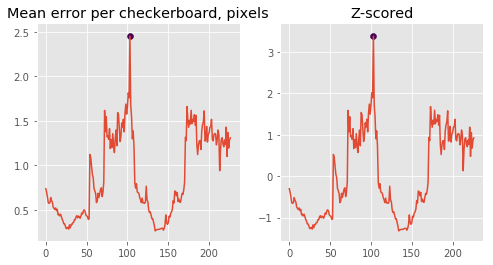

R: [[ 0.329863 -0.004465 -0.944018]
 [ 0.012936  0.999916 -0.00021 ]
 [ 0.94394  -0.012142  0.329893]]
t: [0.153308 0.009938 0.076273]
Euler angles:  [ -2.107936 -70.724166   2.245724]
RMSD: 0.000619


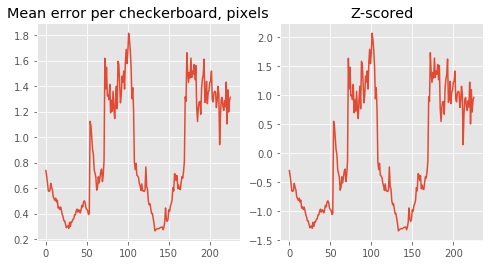

In [254]:
rs.calibrate_iterative(calibdir)

In [255]:
class Transformer():
    """ Class for transforming between the coordinate systems of multiple RealSense pairs.
    Constraints: each neighboring realsense must have somewhat overlapping views!
    
    Example usage:
        transformer = Transformer(...)
        
        cloud_transformed = transformer.transform(cloud, 'left_ant', 'left_post')
        The cloud starts in the 'left_ant' coordinate system, is transformed into the 
            'left_post' coordinate system
    """
    def __init__(self, calibdir, intrinsics, extrinsics, pairs, reference='left_ant'):
        """Constructor for transformer class
        Args:
            Calibdir: directory with stored calibration information (corners)
            intrinsics: dict with intrinsics for each realsense device (keys=camnames)
            Extrinics: dict with extrinsics for each realsense device (keys=camnames)
            pairs: list of tuples. Defines neighboring cameras.
                Cameras are nodes and this tuple defines the edges in a graph.
                Example: [('right_ant', 'right_post'),
                          ('right_post', 'left_post'),
                          ('left_post', 'left_ant')]
                Important considerations: each camera must be present in at least one node
                    Each tuple must contain adjacent cameras.
                    Each tuple must have at least some overlapping view, with checkerboards
                        in their shared view.
            reference: the 'canonical' coordinate frame. must be a camera
        """
        self.rs = {}
        self.R = {}
        self.t = {}
        # make sure we don't edit the list in our environment
        pairs = pairs.copy()
        for pair in pairs:
            # define a realsense pair with each edge of the graph
            rs = RealsensePair(pair, 
                               intrinsics[pair[0]], 
                               extrinsics[pair[0]], 
                               intrinsics[pair[1]], 
                               extrinsics[pair[1]])
            print('~~~ Calibrating pair: ', pair, '~~~')
            # calibrate!
            rs.calibrate_iterative(calibdir)
            # store rotation and translations between each edge
            self.R[pair] = rs.R
            self.t[pair] = rs.t
            # store the inverse transformation as the opposite direction
            # along the edge
            self.R[(pair[1],pair[0])] = rs.R_inv
            self.t[(pair[1],pair[0])] = rs.t_inv
            self.rs[pair] = rs
        # since we added inverse transformations, add to graph
        for i in range(len(pairs)):
            pair = pairs[i]
            pairs.append((pair[1], pair[0]))
            
        self.pairs = pairs
        self.cams = list(intrinsics.keys())
        # formalize this in a graph data structure, which is convenient
        # for things like composing transformations
        self.graph = Graph(self.pairs, directed=True)
        self.calibdir = calibdir
        
    
    def compose_transforms(self, R1, R2, t1, t2):
        """Combine two rigid transformations into one.
        Args:
            R1: [3,3] rotation matrix 1
            R2: [3,3] rotation matrix 2
            t1: [3,1] translation matrix 1
            t2: [3,1] translation matrix 2
        Returns:
            R3: [3,3] rotation matrix, through R1 into R2
            t3: [3,1] rotation matrix
        Example:
            R13 = R23 * R12
            t13 = R23 * T12 + T23
            
            References:
                https://en.wikipedia.org/wiki/Transformation_matrix#Composing_and_inverting_transformations
                http://web.cse.ohio-state.edu/~wang.3602/courses/cse5542-2013-spring/6-Transformation_II.pdf
                https://stackoverflow.com/questions/23750498/composition-of-3d-rigid-transformations
        """
        R3 = R2 @ R1
        t3 = R2 @ t1 + t2
        return(R3,t3)
    
    def compose(self, sequence):
        """Generates transformation from a series of other, known transformations.
        Args:
            Sequence: list of edges. Example:
                [('right_ant', 'right_post'),
                 ('right_post', 'left_post'),
                 ('left_post', 'left_ant')]
                 This would generate a transform from right ant to left ant.
        Returns:
            R3, t3: rigid transformation between first and last node in Sequence.
        Uses recursion to combine first two transformations, then replace that in sequence.
            Combine next two transformations, then replace those, etc...
        """
        src, dest = sequence[0][0], sequence[1][1]
        # combine first two edges into one transformation, which could be a new edge
        R3, t3 = compose_transforms(self.R[sequence[0]], 
                                    self.R[sequence[1]],
                                    self.t[sequence[0]],
                                    self.t[sequence[1]])
        # if the first combination solves the whole sequence, return
        if len(sequence)==2:
            return(R3,t3)
        else:
            # define new edge between newly connected nodes
            pair = (src,dest)
            sequence2 = sequence.copy()
            # delete first two edges
            del(sequence2[0:2])
            # replace with single edge
            sequence2.insert(0, pair)
            # save the new transform in our R dictionary
            self.R[pair] = R3
            self.t[pair] = t3
            # recursively continue, with first edge being the new shorter one
            return(self.compose(sequence2))
        
    def nodes_to_sequence(self, node1,node2):
        path = self.graph.find_shortest_path(node1,node2)
        sequence = []
        for i in range(len(path)-1):
            sequence.append((path[i], path[i+1]))
        return(sequence)
    
    def transform(self, cloud, node1,node2=None):
        if node2 is None:
            node2 = self.reference
            
        if cloud.shape[1] == 3:
            cloud = cloud.T
        if node1 == node2:
            return(cloud)
        pair = (node1, node2)
        
        if pair in list(self.R.keys()):
            R = self.R[pair]
            t = self.t[pair]
        else:
            sequence = self.nodes_to_sequence(node1, node2)
            R, t = self.compose(sequence)
        transformed = R @ cloud + t
        return(transformed)

In [256]:
pairs

[('right_ant', 'right_post'),
 ('right_post', 'left_post'),
 ('left_post', 'left_ant')]

In [257]:
pairs = [('right_ant', 'right_post'),
         ('right_post', 'left_post'),
         ('left_post', 'left_ant')]

In [258]:
%matplotlib inline

~~~ Calibrating pair:  ('right_ant', 'right_post') ~~~
R: [[ 0.329834 -0.004476 -0.944028]
 [ 0.012925  0.999916 -0.000225]
 [ 0.94395  -0.012127  0.329864]]
t: [0.153311 0.009941 0.076277]
Euler angles:  [ -2.105433 -70.725939   2.243994]
RMSD: 0.000643


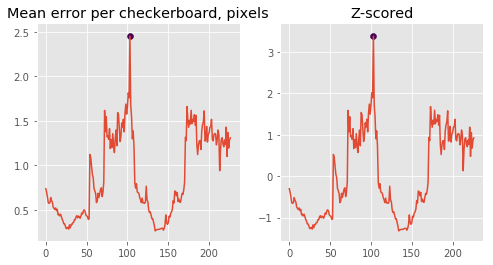

R: [[ 0.329863 -0.004465 -0.944018]
 [ 0.012936  0.999916 -0.00021 ]
 [ 0.94394  -0.012142  0.329893]]
t: [0.153308 0.009938 0.076273]
Euler angles:  [ -2.107936 -70.724166   2.245724]
RMSD: 0.000619


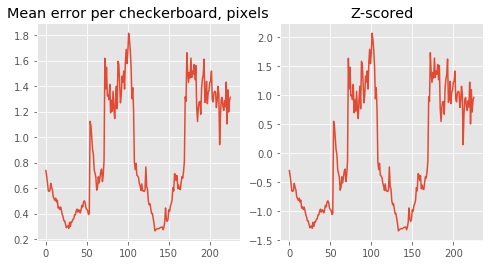

~~~ Calibrating pair:  ('right_post', 'left_post') ~~~
R: [[ 0.713329  0.034569 -0.699976]
 [-0.048291  0.998833  0.000117]
 [ 0.699164  0.033719  0.714166]]
t: [ 0.110353 -0.00463   0.019609]
Euler angles:  [  2.703221 -44.359943  -3.872908]
RMSD: 0.000423


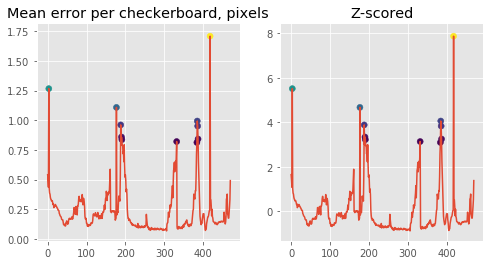

R: [[ 0.713241  0.034609 -0.700064]
 [-0.048346  0.998831  0.000123]
 [ 0.699249  0.033757  0.714081]]
t: [ 0.110373 -0.004627  0.019613]
Euler angles:  [  2.706569 -44.366802  -3.877773]
RMSD: 0.000325


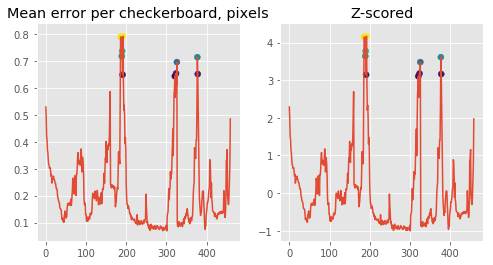

R: [[ 0.713171  0.034681 -0.700131]
 [-0.048422  0.998827  0.000153]
 [ 0.699315  0.033793  0.714014]]
t: [ 0.11039  -0.004624  0.019615]
Euler angles:  [  2.709646 -44.3721    -3.884234]
RMSD: 0.000260


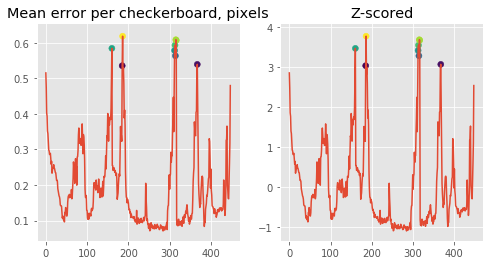

R: [[ 0.713151  0.034682 -0.700152]
 [-0.048432  0.998826  0.000146]
 [ 0.699335  0.033806  0.713994]]
t: [ 0.110395 -0.004622  0.019616]
Euler angles:  [  2.710778 -44.373687  -3.88516 ]
RMSD: 0.000237


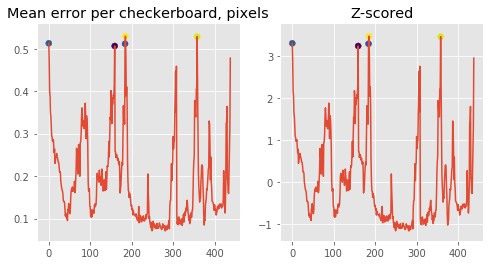

R: [[ 0.713173  0.034658 -0.700131]
 [-0.048416  0.998827  0.000127]
 [ 0.699314  0.033807  0.714014]]
t: [ 0.110391 -0.004621  0.019614]
Euler angles:  [  2.710816 -44.372028  -3.883733]
RMSD: 0.000227


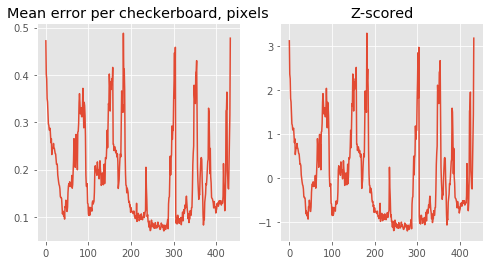

~~~ Calibrating pair:  ('left_post', 'left_ant') ~~~
R: [[-0.002489  0.054955 -0.998486]
 [ 0.041163  0.997648  0.054807]
 [ 0.999149 -0.040964 -0.004745]]
t: [ 0.160355 -0.01055   0.112451]
Euler angles:  [-96.607829 -87.636566  93.46043 ]
RMSD: 0.000626


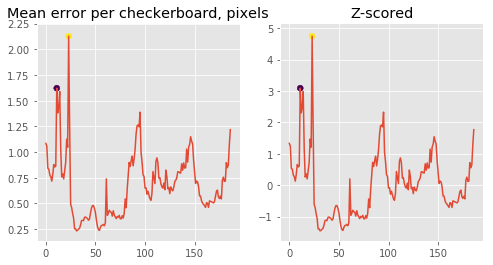

R: [[-0.002591  0.054852 -0.998491]
 [ 0.040935  0.997663  0.0547  ]
 [ 0.999158 -0.040731 -0.00483 ]]
t: [ 0.160357 -0.010522  0.112463]
Euler angles:  [-96.762868 -87.649263  93.621582]
RMSD: 0.000578


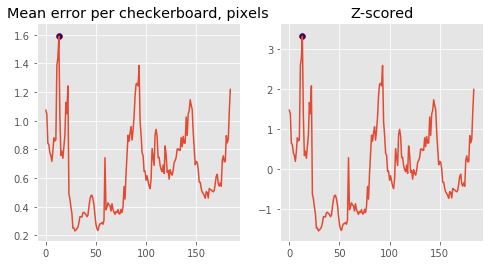

R: [[-0.00257   0.054804 -0.998494]
 [ 0.040963  0.997665  0.054653]
 [ 0.999157 -0.040761 -0.004809]]
t: [ 0.160356 -0.010517  0.112459]
Euler angles:  [-96.728331 -87.647696  93.589751]
RMSD: 0.000543


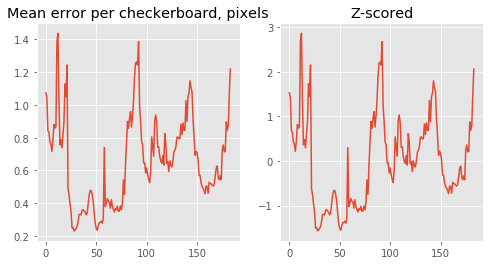

In [259]:
transformer = Transformer(calibdir, intrinsics, extrinsics, pairs)

In [260]:
transformer.R

{('right_ant', 'right_post'): array([[ 0.329863, -0.004465, -0.944018],
        [ 0.012936,  0.999916, -0.00021 ],
        [ 0.94394 , -0.012142,  0.329893]], dtype=float32),
 ('right_post', 'right_ant'): array([[ 0.329863,  0.012936,  0.94394 ],
        [-0.004465,  0.999916, -0.012142],
        [-0.944018, -0.00021 ,  0.329893]], dtype=float32),
 ('right_post', 'left_post'): array([[ 0.713173,  0.034658, -0.700131],
        [-0.048416,  0.998827,  0.000127],
        [ 0.699314,  0.033807,  0.714014]], dtype=float32),
 ('left_post', 'right_post'): array([[ 0.713173, -0.048416,  0.699314],
        [ 0.034658,  0.998827,  0.033807],
        [-0.700131,  0.000127,  0.714014]], dtype=float32),
 ('left_post', 'left_ant'): array([[-0.00257 ,  0.054804, -0.998494],
        [ 0.040963,  0.997665,  0.054653],
        [ 0.999157, -0.040761, -0.004809]], dtype=float32),
 ('left_ant', 'left_post'): array([[-0.00257 ,  0.040963,  0.999157],
        [ 0.054804,  0.997665, -0.040761],
        [-0.99

In [261]:
path = transformer.graph.find_shortest_path('right_ant', 'left_ant')
sequence = []
for i in range(len(path)-1):
    sequence.append((path[i], path[i+1]))

In [262]:
sequence

[('right_ant', 'right_post'),
 ('right_post', 'left_post'),
 ('left_post', 'left_ant')]

In [265]:
cams = tuple(cams)

In [267]:
cams = sequence[0]

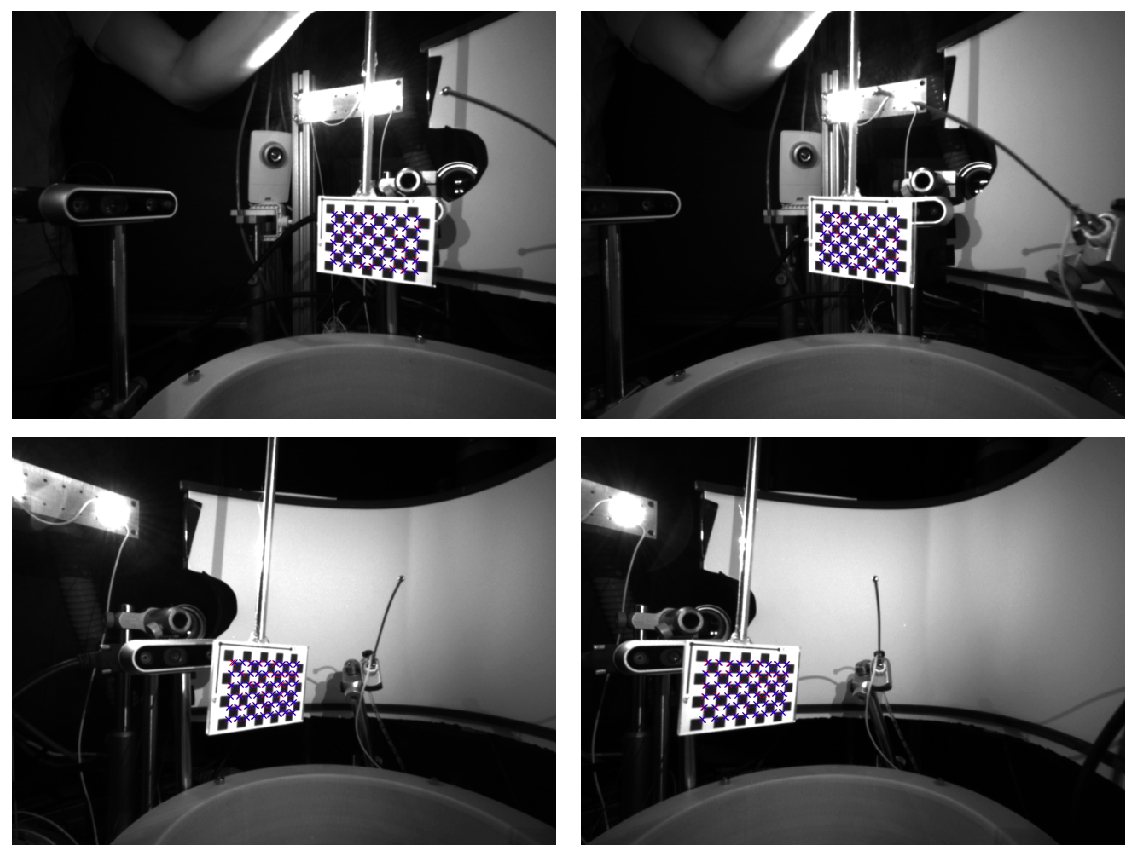

In [271]:
valid_indices = get_valid_camera_pairs(calibdir,  cams)

dataset = PointData(calibdir, cams, intrinsics,extrinsics, valid_indices)
ind = np.random.randint(low=0,high=len(valid_indices))
clouds = dataset[ind]
source, target = clouds[cams[0]], clouds[cams[1]]

target_est = transformer.rs[cams].rotate(source)
source_est = transformer.rs[cams].rotate(target,target_to_source=True)

image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)

results = transformer.rs[cams].reproject(source, target, source_est, target_est)

source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results


plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_l).T
# corners = source_l
plot_corners(source_l, ax, text=plot_text)
# corners = tensor_to_np(source_est_l).T
plot_corners(source_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_r).T
plot_corners(source_r, ax, text=plot_text)
# corners = tensor_to_np(source_est_r).T
plot_corners(source_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(target_l).T
plot_corners(target_l, ax, text=plot_text)
# corners = tensor_to_np(target_est_l).T
plot_corners(target_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# corners = tensor_to_np(target_r).T
plot_corners(target_r, ax, text=plot_text)
# corners = tensor_to_np(target_est_r).T
plot_corners(target_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

In [272]:
transformer.R

{('right_ant', 'right_post'): array([[ 0.329863, -0.004465, -0.944018],
        [ 0.012936,  0.999916, -0.00021 ],
        [ 0.94394 , -0.012142,  0.329893]], dtype=float32),
 ('right_post', 'right_ant'): array([[ 0.329863,  0.012936,  0.94394 ],
        [-0.004465,  0.999916, -0.012142],
        [-0.944018, -0.00021 ,  0.329893]], dtype=float32),
 ('right_post', 'left_post'): array([[ 0.713173,  0.034658, -0.700131],
        [-0.048416,  0.998827,  0.000127],
        [ 0.699314,  0.033807,  0.714014]], dtype=float32),
 ('left_post', 'right_post'): array([[ 0.713173, -0.048416,  0.699314],
        [ 0.034658,  0.998827,  0.033807],
        [-0.700131,  0.000127,  0.714014]], dtype=float32),
 ('left_post', 'left_ant'): array([[-0.00257 ,  0.054804, -0.998494],
        [ 0.040963,  0.997665,  0.054653],
        [ 0.999157, -0.040761, -0.004809]], dtype=float32),
 ('left_ant', 'left_post'): array([[-0.00257 ,  0.040963,  0.999157],
        [ 0.054804,  0.997665, -0.040761],
        [-0.99

In [273]:
class Projector():
    def __init__(self, cams, P_l, P_r):
        # super().__init__()
        
        src_cam, tgt_cam = cams
        self.P_l_src = P_l[src_cam]
        self.P_r_src = P_r[src_cam]
        self.P_l_tgt = P_l[tgt_cam]
        self.P_r_tgt = P_r[tgt_cam]
        
    def append_ones(self, array):
        return(np.concatenate((array, np.ones((1, array.shape[1]), dtype=array.dtype)), axis=0))
    def project(self, x_3d,P):
        if x_3d is None:
            return(None)
        # print(x_3d.dtype)
        homogeneous = self.append_ones(x_3d)
        # print(homogeneous.shape)
        # print(P.shape)
        homogeneous = np.matmul(P, homogeneous)
        # print(homogeneous.shape)
        return(homogeneous[:2,:]/homogeneous[2,:])
    
    def __call__(self, source, target, source_est, target_est):
        source_l = self.project(source, self.P_l_src)
        source_est_l = self.project(source_est, self.P_l_src)
        source_r = self.project(source, self.P_r_src)
        source_est_r = self.project(source_est, self.P_r_src)
        
        target_l = self.project(target, self.P_l_tgt)
        target_est_l = self.project(target_est, self.P_l_tgt)
        target_r = self.project(target, self.P_r_tgt)
        target_est_r = self.project(target_est, self.P_r_tgt)
        
        return(source_l, source_est_l,
              source_r, source_est_r,
              target_l, target_est_l, 
              target_r, target_est_r)

In [274]:
def compose_transforms(R1, R2, t1, t2):
    R3 = R2 @ R1
    t3 = R2@t1 + t2
    return(R3,t3)

In [275]:
sequence

[('right_ant', 'right_post'),
 ('right_post', 'left_post'),
 ('left_post', 'left_ant')]

In [276]:
def compose(transformer, sequence):
    src, dest = sequence[0][0], sequence[1][1]
    R3, t3 = compose_transforms(transformer.R[sequence[0]], 
                                   transformer.R[sequence[1]],
                                   transformer.t[sequence[0]],
                                   transformer.t[sequence[1]])
    if len(sequence)==2:
        return(R3,t3)
    else:
        pair = (src,dest)
        sequence2 = sequence.copy()
        del(sequence2[0:2])
        sequence2.insert(0, pair)
        transformer.R[pair] = R3
        transformer.t[pair] = t3
        return(compose(transformer,sequence2))

In [277]:
cams = ('right_ant', 'left_post')

path = transformer.graph.find_shortest_path(cams[0],cams[1])
sequence = []
for i in range(len(path)-1):
    sequence.append((path[i], path[i+1]))

In [278]:
sequence

[('right_ant', 'right_post'), ('right_post', 'left_post')]

In [279]:
R3, t3 = compose(transformer, sequence)

In [280]:
cams = ('right_ant', 'left_post')

In [281]:
def get_indices_at_least_one_visible(calibdir, cams):
    h5file = os.path.join(calibdir, 'corners.h5')
    with h5py.File(h5file, 'r') as f:
        N = f[cams[0] + '/corners/l'].shape[0]

        all_valid = np.zeros((N,len(cams)), dtype=np.uint8)
        for i in range(len(cams)):
            l = f[cams[i] + '/corners/l'][:]
            r = f[cams[i] + '/corners/r'][:]
            # print(l)
            # print(r)
            # import pdb
            # pdb.set_trace()
            has_corners =  np.array([0 if np.any(np.isnan(j)) or np.any(np.isnan(k)) else 1 for j,k in zip(l,r)])
            all_valid[:,i] = has_corners
    valid_indices = np.where(all_valid.sum(axis=1)>0)[0]
    return(valid_indices)

In [282]:
plt.close('all')

In [284]:
%pdb

Automatic pdb calling has been turned OFF


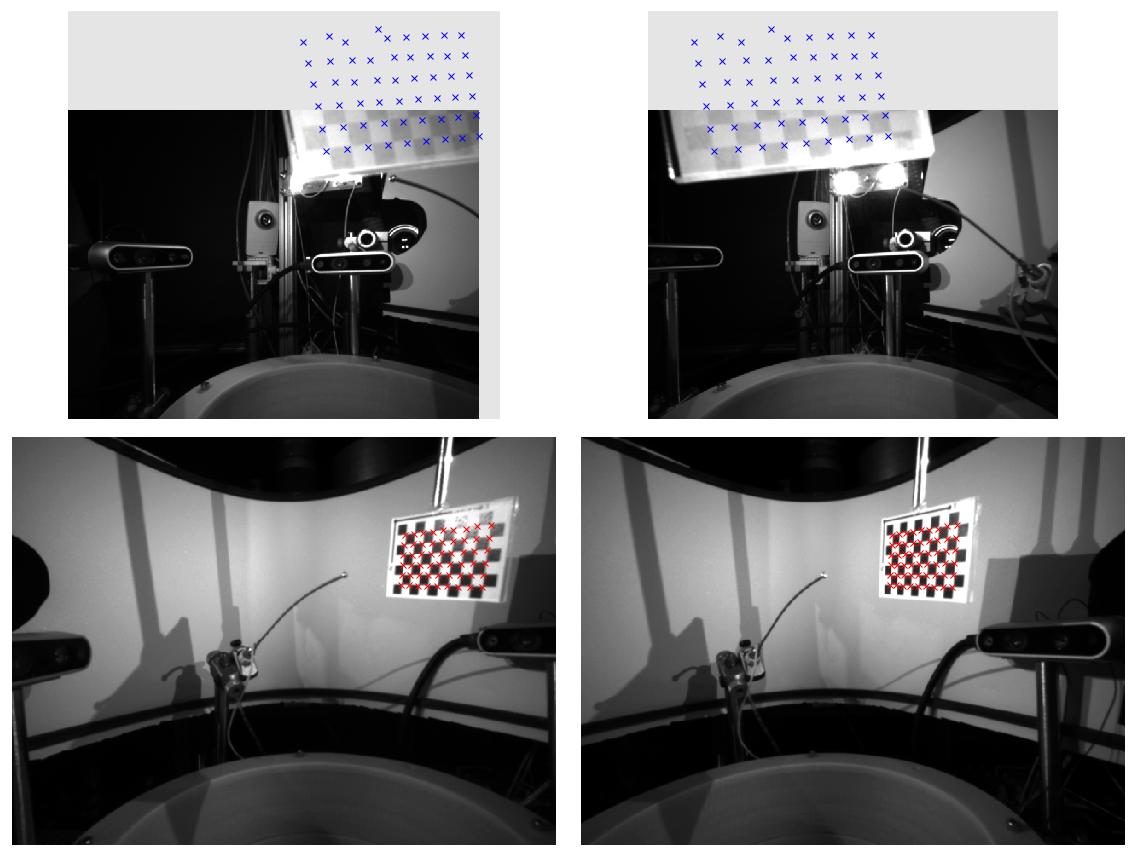

In [286]:
valid_indices = get_indices_at_least_one_visible(calibdir,  cams)

dataset = PointData(calibdir, cams, intrinsics,extrinsics, valid_indices)
projector = Projector(cams, P_l, P_r)
ind = np.random.randint(low=0,high=len(valid_indices))
clouds = dataset[ind]
source = clouds[cams[0]]
target = clouds[cams[1]]

# tar

if source is not None:
    target_est = R3 @ source + t3
else:
    target_est = None
# source_est = transformer.rs[cams].rotate(target,target_to_source=True)
R3_inv, t3_inv = invert_transform(R3,t3)
if target is not None:
    source_est = R3_inv @ target + t3_inv
else:
    source_est = None

if source is not None:
    target_est = transformer.transform(source, cams[0], cams[1])
if target is not None:
    source_est = transformer.transform(target, cams[1], cams[0])
    

image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)

results = projector(source, target, source_est, target_est)

source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_l).T
# corners = source_l
plot_corners(source_l, ax, text=plot_text)
# corners = tensor_to_np(source_est_l).T
plot_corners(source_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_r).T
plot_corners(source_r, ax, text=plot_text)
# corners = tensor_to_np(source_est_r).T
plot_corners(source_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(target_l).T
plot_corners(target_l, ax, text=plot_text)
# corners = tensor_to_np(target_est_l).T
plot_corners(target_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# corners = tensor_to_np(target_r).T
plot_corners(target_r, ax, text=plot_text)
# corners = tensor_to_np(target_est_r).T
plot_corners(target_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

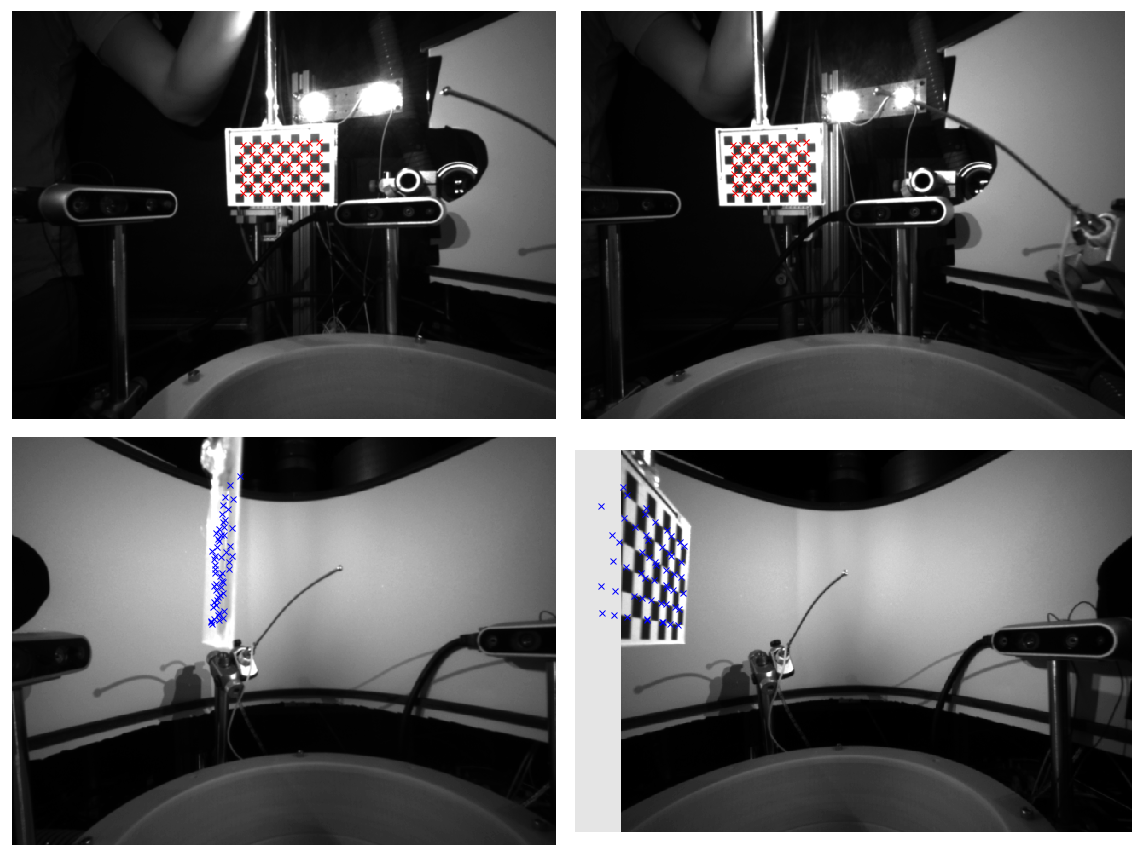

In [289]:
valid_indices = get_indices_at_least_one_visible(calibdir,  cams)

dataset = PointData(calibdir, cams, intrinsics,extrinsics, valid_indices)
ind = np.random.randint(low=0,high=len(valid_indices))
clouds = dataset[ind]
source, target = clouds[cams[0]], clouds[cams[1]]

if source is not None:
    target_est = R3 @ source + t3
else:
    target_est = None
# source_est = transformer.rs[cams].rotate(target,target_to_source=True)
R3_inv, t3_inv = invert_transform(R3,t3)
if target is not None:
    source_est = R3_inv @ target + t3_inv
else:
    source_est = None


image_ind = valid_indices[ind]
lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, image_ind)

results = projector(source, target, source_est, target_est)

source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results

plot_text = False

fig, axes = plt.subplots(2,2,figsize=(16,12))
ax = axes[0,0]
im = lefts[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_l).T
# corners = source_l
plot_corners(source_l, ax, text=plot_text)
# corners = tensor_to_np(source_est_l).T
plot_corners(source_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[0,0].plot(l1[:,:,0], l1[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[0,1]
im = rights[cams[0]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(source_r).T
plot_corners(source_r, ax, text=plot_text)
# corners = tensor_to_np(source_est_r).T
plot_corners(source_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1,0]
im = lefts[cams[1]]
ax.imshow(im, 'gray')
# corners = tensor_to_np(target_l).T
plot_corners(target_l, ax, text=plot_text)
# corners = tensor_to_np(target_est_l).T
plot_corners(target_est_l, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# ax[1,0].plot(l2[:,:,0], l2[:,:,1], 'ro',markersize=2.5, alpha=0.5)

ax = axes[1,1]
im = rights[cams[1]]
ax.imshow(im, 'gray')
# ax[1,1].plot(r2[:,:,0], r2[:,:,1], 'ro',markersize=2.5, alpha=0.5)
# corners = tensor_to_np(target_r).T
plot_corners(target_r, ax, text=plot_text)
# corners = tensor_to_np(target_est_r).T
plot_corners(target_est_r, ax, text=plot_text, color='b')
ax.set_xticks([])
ax.set_yticks([])
# fig.suptitle('Calibration', fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
plt.show()

# Visualizing all images with at least one checkerboard detected

In [290]:
cams = ['left_ant', 'left_post', 'right_ant', 'right_post']
# cams = ['right_ant', 'right_post']
valid_indices = get_indices_at_least_one_visible(calibdir, cams)

~~~ Calibrating pair:  ('right_ant', 'right_post') ~~~
R: [[ 0.329834 -0.004476 -0.944028]
 [ 0.012925  0.999916 -0.000225]
 [ 0.94395  -0.012127  0.329864]]
t: [0.153311 0.009941 0.076277]
Euler angles:  [ -2.105433 -70.725939   2.243994]
RMSD: 0.000643


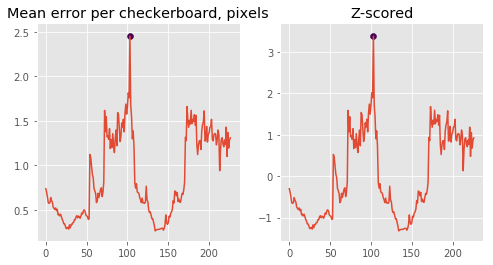

R: [[ 0.329863 -0.004465 -0.944018]
 [ 0.012936  0.999916 -0.00021 ]
 [ 0.94394  -0.012142  0.329893]]
t: [0.153308 0.009938 0.076273]
Euler angles:  [ -2.107936 -70.724166   2.245724]
RMSD: 0.000619


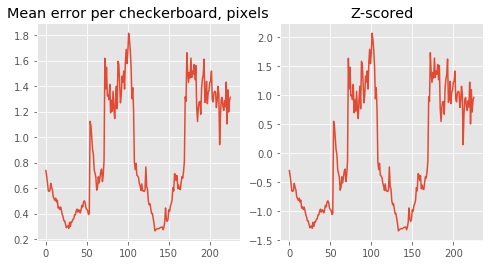

~~~ Calibrating pair:  ('right_post', 'left_post') ~~~
R: [[ 0.713329  0.034569 -0.699976]
 [-0.048291  0.998833  0.000117]
 [ 0.699164  0.033719  0.714166]]
t: [ 0.110353 -0.00463   0.019609]
Euler angles:  [  2.703221 -44.359943  -3.872908]
RMSD: 0.000423


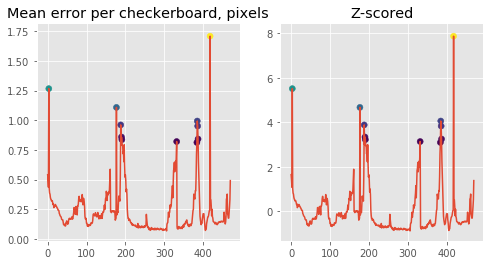

R: [[ 0.713241  0.034609 -0.700064]
 [-0.048346  0.998831  0.000123]
 [ 0.699249  0.033757  0.714081]]
t: [ 0.110373 -0.004627  0.019613]
Euler angles:  [  2.706569 -44.366802  -3.877773]
RMSD: 0.000325


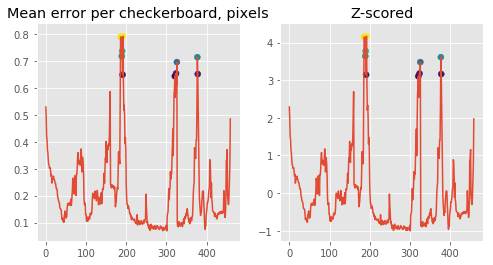

R: [[ 0.713171  0.034681 -0.700131]
 [-0.048422  0.998827  0.000153]
 [ 0.699315  0.033793  0.714014]]
t: [ 0.11039  -0.004624  0.019615]
Euler angles:  [  2.709646 -44.3721    -3.884234]
RMSD: 0.000260


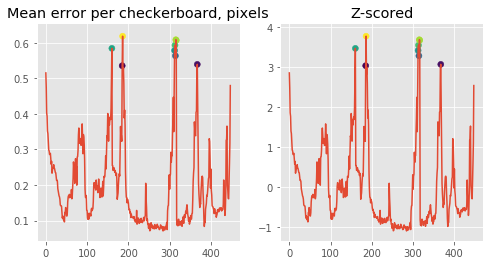

R: [[ 0.713151  0.034682 -0.700152]
 [-0.048432  0.998826  0.000146]
 [ 0.699335  0.033806  0.713994]]
t: [ 0.110395 -0.004622  0.019616]
Euler angles:  [  2.710778 -44.373687  -3.88516 ]
RMSD: 0.000237


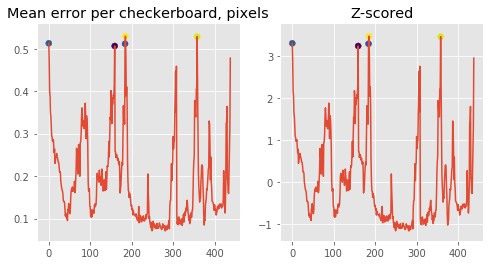

R: [[ 0.713173  0.034658 -0.700131]
 [-0.048416  0.998827  0.000127]
 [ 0.699314  0.033807  0.714014]]
t: [ 0.110391 -0.004621  0.019614]
Euler angles:  [  2.710816 -44.372028  -3.883733]
RMSD: 0.000227


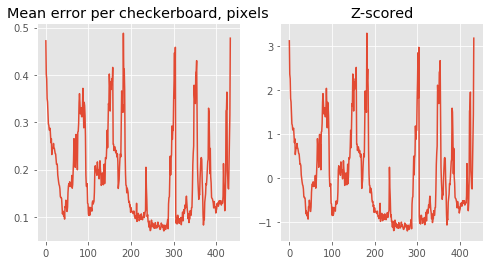

~~~ Calibrating pair:  ('left_post', 'left_ant') ~~~
R: [[-0.002489  0.054955 -0.998486]
 [ 0.041163  0.997648  0.054807]
 [ 0.999149 -0.040964 -0.004745]]
t: [ 0.160355 -0.01055   0.112451]
Euler angles:  [-96.607829 -87.636566  93.46043 ]
RMSD: 0.000626


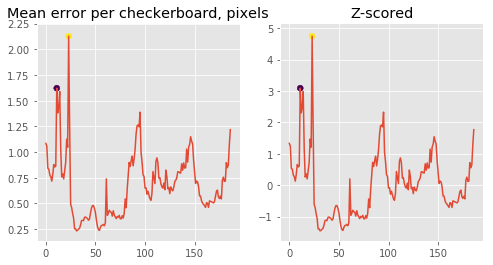

R: [[-0.002591  0.054852 -0.998491]
 [ 0.040935  0.997663  0.0547  ]
 [ 0.999158 -0.040731 -0.00483 ]]
t: [ 0.160357 -0.010522  0.112463]
Euler angles:  [-96.762868 -87.649263  93.621582]
RMSD: 0.000578


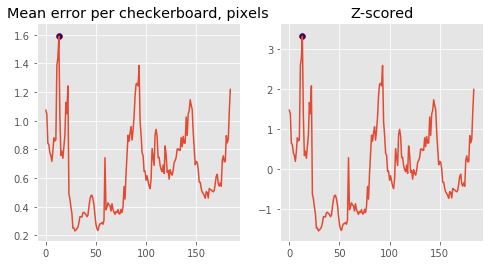

R: [[-0.00257   0.054804 -0.998494]
 [ 0.040963  0.997665  0.054653]
 [ 0.999157 -0.040761 -0.004809]]
t: [ 0.160356 -0.010517  0.112459]
Euler angles:  [-96.728331 -87.647696  93.589751]
RMSD: 0.000543


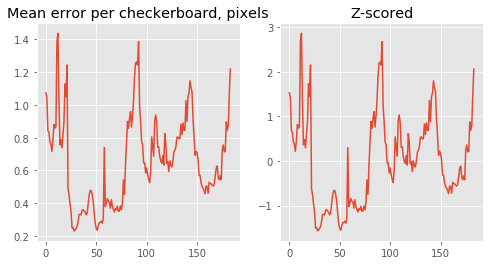

In [291]:
transformer = Transformer(calibdir, intrinsics, extrinsics, pairs)

In [292]:
dataset = PointData(calibdir, cams, intrinsics,extrinsics, valid_indices)

In [295]:
%matplotlib qt5

In [296]:
ind = np.random.randint(low=0, high=len(dataset))
clouds = dataset[ind]


plt.close('all')
for key,value in clouds.items():
    if value is not None:
        source_cam =key

lefts, rights = get_frames_by_index_uncompressed(calibims, LUT, valid_indices[ind])

fig, axes = plt.subplots(2,4,figsize=(16,10))

cam = cams[0]
color = 'r' if cam == source_cam else 'b'
ax = axes[0,0]
ax.imshow(lefts[cam], 'gray')
projector = Projector((source_cam,cam),P_l,P_r)
source = clouds[source_cam]
target = clouds[cam]
if target is not None:
    source_est = transformer.transform(target, cam,source_cam)
else:
    source_est = None
target_est = transformer.transform(source, source_cam, cam)

results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results
# plot_corners(source_l, ax, text=plot_text)
plot_corners(target_est_l, ax, text=plot_text, color=color)
ax = axes[0,1]
ax.imshow(rights[cam], 'gray')
# plot_corners(source_r, ax, text=plot_text)
plot_corners(target_est_r, ax, text=plot_text, color=color)


cam = cams[1]
color = 'r' if cam == source_cam else 'b'
ax = axes[0,2]
ax.imshow(lefts[cam], 'gray')
projector = Projector((source_cam,cam),P_l,P_r)
source = clouds[source_cam]
target = clouds[cam]
if target is not None:
    source_est = transformer.transform(target, cam,source_cam)
else:
    source_est = None
target_est = transformer.transform(source, source_cam, cam)

results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results
plot_corners(target_est_l, ax, text=plot_text, color=color)
ax = axes[0,3]
ax.imshow(rights[cam], 'gray')
plot_corners(target_est_r, ax, text=plot_text, color=color)



cam = cams[2]
color = 'r' if cam == source_cam else 'b'
ax = axes[1,0]
ax.imshow(lefts[cam], 'gray')
projector = Projector((source_cam,cam),P_l,P_r)
source = clouds[source_cam]
target = clouds[cam]
if target is not None:
    source_est = transformer.transform(target, cam,source_cam)
else:
    source_est = None
target_est = transformer.transform(source, source_cam, cam)

results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results
plot_corners(target_est_l, ax, text=plot_text, color=color)
ax = axes[1,1]
ax.imshow(rights[cam], 'gray')
plot_corners(target_est_r, ax, text=plot_text, color=color)


cam = cams[3]
color = 'r' if cam == source_cam else 'b'
ax = axes[1,2]
ax.imshow(lefts[cam], 'gray')
projector = Projector((source_cam,cam),P_l,P_r)
source = clouds[source_cam]
target = clouds[cam]
if target is not None:
    source_est = transformer.transform(target, cam,source_cam)
else:
    source_est = None
target_est = transformer.transform(source, source_cam, cam)

results = projector(source, target, source_est, target_est)
source_l, source_est_l,source_r, source_est_r,target_l, target_est_l, target_r, target_est_r = results
plot_corners(target_est_l, ax, text=plot_text, color=color)
ax = axes[1,3]
ax.imshow(rights[cam], 'gray')
plot_corners(target_est_r, ax, text=plot_text, color=color)


plt.tight_layout()
plt.show()